<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Data and Kaggle Challenge

### Contents:
- [Background and Problem Statement](#Background-and-Problem-Statemen)
- [Data Import & Cleaning](#Data-Importing-&-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))
- [Modeling](#Modeling)
- [Kaggle Submission](#Kaggle-Submission)
- [Key Insights & Recommendations](#Key-Insights-&-Recommendations)

## Background

In Singapore's dynamic housing market, the resale prices of public housing flats (HDB flats) are influenced by a myriad of factors including flat characteristics, nearby amenities, socio-economic variables and more. Accurate prediction of HDB flat resale prices is of significant importance to buyers, sellers, and policy-makers alike, for informed decision-making and planning.

Given a dataset comprising a variety of features such as transaction year, town, flat type, block number, street name, storey range, floor area, flat model, lease commence date, and other socio-economic and locational variables, the task is to design and deploy robust regression models that accurately predict the resale price of HDB flat


### Datasets

* [`train.csv`](../datasets/train.csv): the csv file this data contains all of the training data for our model. The target variable (SalePrice) is removed from the test set! The detailed descriptions of the csv file could be found [here](https://www.kaggle.com/competitions/dsi-sg-project-2-regression-challenge-hdb-price/data).
* [`test.csv`](../datasets/test.csv): the csv file contains the test data for our model. We will feed this data into your regression model to make predictions. The detailed descriptions of the csv file could be found [here](https://www.kaggle.com/competitions/dsi-sg-project-2-regression-challenge-hdb-price/data).


## Problem Statement

**We are a real estate start-up company in Singapore. HDB resale flat prices span a big range and seem to be influenced by different features of the flat. The general public may not be well-equipped with the information needed to aid their decision making process. We have decided to develop a product where the general public can check the predicted HDB resale flat pricing, and answer common questions below.**

(1) What are the options I have given my current budget?  
(2) Which flat type and where can I afford as a buyer?  
(3) What price should I set when I plan to sell my flat?  
(4) How to market my flat to increase its selling price?  


## Project Goals

1. **Data Analysis**: conduct a comprehensive exploratory data analysis

2. **Variable Importance and Feature Engineering**: Identify and engineer features have the most impact on the resale price. 

3. **Model Deployment**: deploy Linear Regression, Ridge Regression and Lasso Regression model and receive an estimated resale price.

4. **Model Comparison**: compare the performance of linear, ridge, and lasso regression models in terms of accuracy, the interpretability of the models and their robustness to changes in the dataset.

5. **Prediction Accuracy**: Ultimately, the goal is to build a model that accurately predicts the resale price of an HDB flat based on the given features.

### Outside Research & Datasets

(1) In Singapore, the allocation of primary school places prioritises students living within close proximity to the school, with higher chances given to those within 1 kilometer. School relocations between 1999 and 2009 were found to impact private housing prices within a 1-kilometer radius, resulting in a 5.5% increase, particularly influenced by the popularity ranking of the school.

* [`pri_sch_popularity.csv`](../datasets/pri_sch_popularity.csv): the csv file contains a popularity ranking among 132 primary schools in Singapore in year 2020, which corresponds well to our housing price datasets (2012 - 2021).

The data above are abstracted from [Straits Times](https://www.straitstimes.com/singapore/parenting-education/home-sale-and-rental-prices-may-rise-after-changes-to-p1-registration) and [Schlah](https://schlah.com/primary-schools), a website that aims to discover the right school for the user.


(2) The URA Property Price Index (PPI) has an upward trend across the years.
* The Housing Price Index from 1990 to 2019
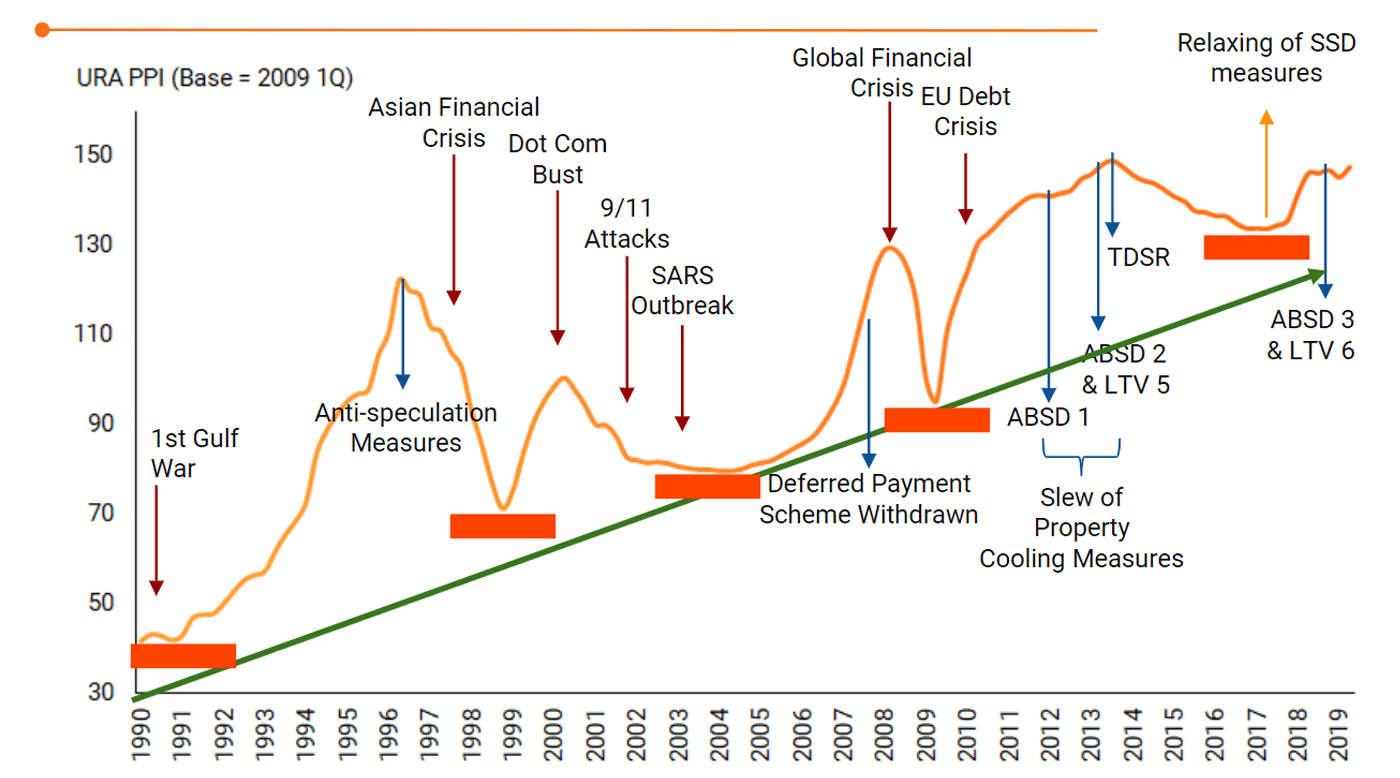

The information and graph above are abstracted from a [personal blog](https://darrenong.sg/blog/is-it-profitable-to-buy-property-during-a-crisis/amp/) of a real estate Associate District Director of Huttons Asia Pte Ltd. 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

from patsy import dmatrices, dmatrix
from yellowbrick.regressor import prediction_error

In [2]:
# To increase the visible rows & cols
pd.options.display.max_rows = 150
pd.options.display.max_columns = 300

## Data Importing & Cleaning

In [3]:
# Import training data from train.csv
housing_df = pd.read_csv('../datasets/train.csv')
housing_df.head()

C:\Users\LENOVO YOGA CORE I5\AppData\Local\Temp\ipykernel_5212\297364759.py:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  housing_df = pd.read_csv('../datasets/train.csv')


id Tranc_YearMonth             town  flat_type block       street_name  \
0   88471         2016-05  KALLANG/WHAMPOA     4 ROOM    3B  UPP BOON KENG RD   
1  122598         2012-07           BISHAN     5 ROOM   153      BISHAN ST 13   
2  170897         2013-07      BUKIT BATOK  EXECUTIVE  289B    BT BATOK ST 25   
3   86070         2012-04           BISHAN     4 ROOM   232      BISHAN ST 22   
4  153632         2017-12           YISHUN     4 ROOM   876      YISHUN ST 81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  resale_price  \
0     10 TO 12            90.0     Model A                 2006      680000.0   
1     07 TO 09           130.0    Improved                 1987      665000.0   
2     13 TO 15           144.0   Apartment                 1997      838000.0   
3     01 TO 05           103.0     Model A                 1992      550000.0   
4     01 TO 03            83.0  Simplified                 1987      298000.0   

   Tranc_Year  Tranc_Month  mid_storey  lower  upper  mid  \
0        2016            5          11     10     12   11   
1        2012            7           8      7      9    8   
2        2013            7          14     13     15   14   
3        2012            4           3      1      5    3   
4        2017           12           2      1      3    2   

        full_flat_type               address  floor_area_sqft  price_per_sqft  \
0       4 ROOM Model A  3B, UPP BOON KENG RD          968.760      701.928238   
1      5 ROOM Improved     153, BISHAN ST 13         1399.320      475.230826   
2  EXECUTIVE Apartment  289B, BT BATOK ST 25         1550.016      540.639580   
3       4 ROOM Model A     232, BISHAN ST 22         1108.692      496.080066   
4    4 ROOM Simplified     876, YISHUN ST 81          893.412      333.552717   

   hdb_age  max_floor_lvl  year_completed residential commercial  \
0       15             25            2005           Y          N   
1       34              9            1987           Y          N   
2       24             16            1996           Y          N   
3       29             11            1990           Y          Y   
4       34              4            1987           Y          N   

  market_hawker multistorey_carpark precinct_pavilion  total_dwelling_units  \
0             N                   N                 N                   142   
1             N                   N                 N                   112   
2             N                   N                 N                    90   
3             N                   N                 N                    75   
4             N                   N                 N                    48   

   1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  \
0           0           0           0          96          46          0   
1           0           0           0          56          56          0   
2           0           0           0           0          30         60   
3           0           0           0          68           7          0   
4           0           0           0          30          18          0   

   multigen_sold  studio_apartment_sold  1room_rental  2room_rental  \
0              0                      0             0             0   
1              0                      0             0             0   
2              0                      0             0             0   
3              0                      0             0             0   
4              0                      0             0             0   

   3room_rental  other_room_rental  postal  Latitude   Longitude  \
0             0                  0  382003  1.314299  103.872828   
1             0                  0  570153  1.346086  103.855078   
2             0                  0  651289  1.343867  103.760535   
3             0                  0  570232  1.358245  103.845504   
4             0                  0  760876  1.414745  103.835532   

  

In [4]:
housing_df.shape

(150634, 78)

In [5]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 78 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey                 15

**Datasets**

Primary School Popularity
- https://schlah.com/primary-schools
    -**pri_sch_popularity dataset : contains schools ranked based on Popularity in Primary 1 (P1) Registration. Note: 186 schools in total, but lowest ranking is 132 only.**

In [6]:
# Importing Primary school popularity data
psch_pop_df = pd.read_csv('../datasets/pri_sch_popularity.csv')
display(psch_pop_df.head(5))
print(psch_pop_df.info())

pri_sch_name  pop_ranking
0               Nan Hua Primary School            1
1    CHIJ Saint Nicholas Girls' School            2
2  Pei Hwa Presbyterian Primary School            3
3                        Rosyth School            4
4                       Ai Tong School            5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pri_sch_name  186 non-null    object
 1   pop_ranking   186 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB
None


In [7]:
# Check for null values
housing_df.isna().sum()

id                               0
Tranc_YearMonth                  0
town                             0
flat_type                        0
block                            0
street_name                      0
storey_range                     0
floor_area_sqm                   0
flat_model                       0
lease_commence_date              0
resale_price                     0
Tranc_Year                       0
Tranc_Month                      0
mid_storey                       0
lower                            0
upper                            0
mid                              0
full_flat_type                   0
address                          0
floor_area_sqft                  0
price_per_sqft                   0
hdb_age                          0
max_floor_lvl                    0
year_completed                   0
residential                      0
commercial                       0
market_hawker                    0
multistorey_carpark              0
precinct_pavilion   

In [8]:
# For mall nearest distance, if there is no data, we assign the null value to the cell instead of NaN.
# For the other columns with NaN (Mall_Within_500m/1km/25 and Hawker_Within_500/1km/2km), it is more of a data entry issue 
# where NaN was supposed to be 0 (cross checked against Mall/Hawker_Nearest_Distance given)

housing_df.fillna(0, inplace=True)

In [9]:
# Verify if all the null values have been filled
housing_df.isna().sum().sum()

0

In [10]:
housing_df.columns

Index(['id', 'Tranc_YearMonth', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'Tranc_Year', 'Tranc_Month', 'mid_storey', 'lower',
       'upper', 'mid', 'full_flat_type', 'address', 'floor_area_sqft',
       'price_per_sqft', 'hdb_age', 'max_floor_lvl', 'year_completed',
       'residential', 'commercial', 'market_hawker', 'multistorey_carpark',
       'precinct_pavilion', 'total_dwelling_units', '1room_sold', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'postal', 'Latitude', 'Longitude', 'planning_area',
       'Mall_Nearest_Distance', 'Mall_Within_500m', 'Mall_Within_1km',
       'Mall_Within_2km', 'Hawker_Nearest_Distance', 'Hawker_Within_500m',
       'Hawker_Within_1km', 'Hawker_Within_2km', 'hawker_food_stalls',
       'hawker_m

The feature names of the dataset seems to have uppercase. Lets standardise the case for all the feature names.

In [11]:
# Standardise the column names to lower case
housing_df.rename(str.lower, axis=1, inplace=True)
housing_df.columns

Index(['id', 'tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'tranc_year', 'tranc_month', 'mid_storey', 'lower',
       'upper', 'mid', 'full_flat_type', 'address', 'floor_area_sqft',
       'price_per_sqft', 'hdb_age', 'max_floor_lvl', 'year_completed',
       'residential', 'commercial', 'market_hawker', 'multistorey_carpark',
       'precinct_pavilion', 'total_dwelling_units', '1room_sold', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'postal', 'latitude', 'longitude', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_m

### Data cleaning: intial check on 'postal'

In [12]:
# Check data column type
housing_df['postal'].dtypes

dtype('O')

In [13]:
# Change all data type to string
housing_df['postal']=housing_df['postal'].astype(str)

In [14]:
# Postal codes are 6 digits long. Check if there is any abnormal data
postal_issues=housing_df[housing_df['postal'].str.len() !=6]
postal_issues['postal']

275       90107
319       58340
600       80009
651       90001
833       90028
          ...  
150282    90020
150477    50004
150524    85701
150557    90005
150573    52335
Name: postal, Length: 2073, dtype: object

In [15]:
# A quick glance at postal_issues show that for some postal codes, the front '0' was dropped, resulting in postal code with 5 digits only
# In housing_df, add this '0' at the front
housing_df['postal']=housing_df['postal'].apply(lambda x: ('0' + x) if len(x)==5 else x)

In [16]:
# Check again
postal_issues=housing_df[housing_df['postal'].str.len() !=6]
postal_issues['postal']

880       NIL
3030      NIL
5793      NIL
7849      NIL
9804      NIL
14007     NIL
43215     NIL
48780     NIL
51263     NIL
51951     NIL
52403     NIL
54179     NIL
57224     NIL
61100     NIL
62338     NIL
64384     NIL
66613     NIL
75486     NIL
75494     NIL
76656     NIL
76787     NIL
82841     NIL
87213     NIL
104383    NIL
105835    NIL
107511    NIL
108757    NIL
119777    NIL
126400    NIL
129756    NIL
131736    NIL
132994    NIL
144514    NIL
Name: postal, dtype: object

In [17]:
# The check revealed that there are some flats with postal showed as 'NIL'.
# Gather the unique addresses for which this has occured into a list.
nil_postal_add=postal_issues[postal_issues['postal'].str.len() !=6]['address'].unique().tolist()
nil_postal_add

['215, CHOA CHU KANG CTRL', '238, COMPASSVALE WALK']

In [18]:
# There are 2 unique addresses for which postal is missing. 
# A quick check on googlemaps allows us to find the postal codes for these addresses.
nil_postal_values=['680215', '540238']

In [19]:
# Assign the postal values found, ensuring we are working with main housing_df
housing_df.loc[housing_df['address']==nil_postal_add[0], 'postal']=nil_postal_values[0]
housing_df.loc[housing_df['address']==nil_postal_add[1], 'postal']=nil_postal_values[1]

In [20]:
# Check again
postal_issues=housing_df[housing_df['postal'].str.len() !=6]
postal_issues

Empty DataFrame
Columns: [id, tranc_yearmonth, town, flat_type, block, street_name, storey_range, floor_area_sqm, flat_model, lease_commence_date, resale_price, tranc_year, tranc_month, mid_storey, lower, upper, mid, full_flat_type, address, floor_area_sqft, price_per_sqft, hdb_age, max_floor_lvl, year_completed, residential, commercial, market_hawker, multistorey_carpark, precinct_pavilion, total_dwelling_units, 1room_sold, 2room_sold, 3room_sold, 4room_sold, 5room_sold, exec_sold, multigen_sold, studio_apartment_sold, 1room_rental, 2room_rental, 3room_rental, other_room_rental, postal, latitude, longitude, planning_area, mall_nearest_distance, mall_within_500m, mall_within_1km, mall_within_2km, hawker_nearest_distance, hawker_within_500m, hawker_within_1km, hawker_within_2km, hawker_food_stalls, hawker_market_stalls, mrt_nearest_distance, mrt_name, bus_interchange, mrt_interchange, mrt_latitude, mrt_longitude, bus_stop_nearest_distance, bus_stop_name, bus_stop_latitude, bus_stop_longitude, pri_sch_nearest_distance, pri_sch_name, vacancy, pri_sch_affiliation, pri_sch_latitude, pri_sch_longitude, sec_sch_nearest_dist, sec_sch_name, cutoff_point, affiliation, sec_sch_latitude, sec_sch_longitude]
Index: []

The categorical features of the dataset are filled with irregular format such as uppercase, empty spaces, etc. Lets standardise all the values by replacing spaces with _ & change all to lowercase.

In [21]:
# Loop through the object features and replace the spaces with '_' and change all to lower cases
for feature in housing_df.select_dtypes(include='object'):
    housing_df[feature] = housing_df[feature].replace(to_replace=' ', value='_', regex=True).str.lower()

In [22]:
housing_df.head()

id tranc_yearmonth             town  flat_type block       street_name  \
0   88471         2016-05  kallang/whampoa     4_room    3b  upp_boon_keng_rd   
1  122598         2012-07           bishan     5_room   153      bishan_st_13   
2  170897         2013-07      bukit_batok  executive  289b    bt_batok_st_25   
3   86070         2012-04           bishan     4_room   232      bishan_st_22   
4  153632         2017-12           yishun     4_room   876      yishun_st_81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  resale_price  \
0     10_to_12            90.0     model_a                 2006      680000.0   
1     07_to_09           130.0    improved                 1987      665000.0   
2     13_to_15           144.0   apartment                 1997      838000.0   
3     01_to_05           103.0     model_a                 1992      550000.0   
4     01_to_03            83.0  simplified                 1987      298000.0   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2016            5          11     10     12   11   
1        2012            7           8      7      9    8   
2        2013            7          14     13     15   14   
3        2012            4           3      1      5    3   
4        2017           12           2      1      3    2   

        full_flat_type               address  floor_area_sqft  price_per_sqft  \
0       4_room_model_a  3b,_upp_boon_keng_rd          968.760      701.928238   
1      5_room_improved     153,_bishan_st_13         1399.320      475.230826   
2  executive_apartment  289b,_bt_batok_st_25         1550.016      540.639580   
3       4_room_model_a     232,_bishan_st_22         1108.692      496.080066   
4    4_room_simplified     876,_yishun_st_81          893.412      333.552717   

   hdb_age  max_floor_lvl  year_completed residential commercial  \
0       15             25            2005           y          n   
1       34              9            1987           y          n   
2       24             16            1996           y          n   
3       29             11            1990           y          y   
4       34              4            1987           y          n   

  market_hawker multistorey_carpark precinct_pavilion  total_dwelling_units  \
0             n                   n                 n                   142   
1             n                   n                 n                   112   
2             n                   n                 n                    90   
3             n                   n                 n                    75   
4             n                   n                 n                    48   

   1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  \
0           0           0           0          96          46          0   
1           0           0           0          56          56          0   
2           0           0           0           0          30         60   
3           0           0           0          68           7          0   
4           0           0           0          30          18          0   

   multigen_sold  studio_apartment_sold  1room_rental  2room_rental  \
0              0                      0             0             0   
1              0                      0             0             0   
2              0                      0             0             0   
3              0                      0             0             0   
4              0                      0             0             0   

   3room_rental  other_room_rental  postal  latitude   longitude  \
0             0                  0  382003  1.314299  103.872828   
1             0                  0  570153  1.346086  103.855078   
2             0                  0  651289  1.343867  103.760535   
3             0                  0  570232  1.358245  103.845504   
4             0                  0  760876  1.414745  103.835532   

  

Data cleaning for Primary School Popularity dataset. As there are sentence cap and empty spaces, lets clean up the name.

In [23]:
psch_pop_df.head()

pri_sch_name  pop_ranking
0               Nan Hua Primary School            1
1    CHIJ Saint Nicholas Girls' School            2
2  Pei Hwa Presbyterian Primary School            3
3                        Rosyth School            4
4                       Ai Tong School            5

In [24]:
# Loop through the primary school name features and replace the spaces with '_' and change all to lower cases
psch_pop_df['pri_sch_name'] = psch_pop_df['pri_sch_name'].replace(to_replace=' ', value='_', regex=True).str.lower()
psch_pop_df.head()

pri_sch_name  pop_ranking
0               nan_hua_primary_school            1
1    chij_saint_nicholas_girls'_school            2
2  pei_hwa_presbyterian_primary_school            3
3                        rosyth_school            4
4                       ai_tong_school            5

## Feature Engineering

### Working with postal code
Instead of working with individual towns (there are numerous!) or the 28 districts, we have decided to work classify the flats into the following [regions as defined by the Urban Redevelopment Authority](https://www.redbrick.sg/blog/singapore-districts-and-regions/):
 * Core Central Region (CCR)
 * Rest of Central Region (RCR)
 * Outside Central Region (OCR)
 
 From each postal code, the first 2 digits are the [postal sector](https://www.mingproperty.sg/singapore-district-code/).


In [25]:
# Obtaining postal sector
housing_df['postal_sector']=housing_df['postal'].str[:2]

In [26]:
# Classifying by postal sector
CCR_postal_sector=['01', '02', '03', '04', '05', '06', '07', '08', '17', '22', '23', '24', '25', '26', '27', '28', '29', '30']
RCR_postal_sector=['14', '15', '16', '09', '10', '11', '12', '13', '18', '19', '20', '21', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '56', '57']
OCR_postal_sector=['46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '77', '78', '81', '82']

In [27]:
# Assigning housing region
housing_df.loc[housing_df['postal_sector'].isin(CCR_postal_sector), 'housing_region'] = 'CCR'
housing_df.loc[housing_df['postal_sector'].isin(RCR_postal_sector), 'housing_region'] = 'RCR'
housing_df.loc[~housing_df['postal_sector'].isin(CCR_postal_sector + RCR_postal_sector), 'housing_region'] = 'OCR'

In [28]:
# Get dummies for housing region
housing_region_dummy=pd.get_dummies(housing_df['housing_region'], prefix='housing_region')

In [29]:
# Concat dummies for housing region into the main housing_df
housing_df=pd.concat([housing_df, housing_region_dummy], axis=1)

In [30]:
housing_df

id tranc_yearmonth             town         flat_type block  \
0        88471         2016-05  kallang/whampoa            4_room    3b   
1       122598         2012-07           bishan            5_room   153   
2       170897         2013-07      bukit_batok         executive  289b   
3        86070         2012-04           bishan            4_room   232   
4       153632         2017-12           yishun            4_room   876   
...        ...             ...              ...               ...   ...   
150629   39814         2020-09        woodlands         executive   849   
150630  147177         2017-06      jurong_west            5_room  648d   
150631  179087         2020-12            bedok         executive   639   
150632   21309         2016-05       queenstown            3_room    32   
150633  185947         2018-06           yishun  multi-generation   666   

               street_name storey_range  floor_area_sqm        flat_model  \
0         upp_boon_keng_rd     10_to_12            90.0           model_a   
1             bishan_st_13     07_to_09           130.0          improved   
2           bt_batok_st_25     13_to_15           144.0         apartment   
3             bishan_st_22     01_to_05           103.0           model_a   
4             yishun_st_81     01_to_03            83.0        simplified   
...                    ...          ...             ...               ...   
150629     woodlands_st_82     04_to_06           161.0         apartment   
150630   jurong_west_st_61     04_to_06           110.0          improved   
150631  bedok_reservoir_rd     10_to_12           144.0         apartment   
150632          holland_cl     07_to_09            59.0          improved   
150633        yishun_ave_4     07_to_09           164.0  multi_generation   

        lease_commence_date  resale_price  tranc_year  tranc_month  \
0                      2006      680000.0        2016            5   
1                      1987      665000.0        2012            7   
2                      1997      838000.0        2013            7   
3                      1992      550000.0        2012            4   
4                      1987      298000.0        2017           12   
...                     ...           ...         ...          ...   
150629                 1995      625000.0        2020            9   
150630                 2001      455000.0        2017            6   
150631                 1993      733000.0        2020           12   
150632                 1974      338000.0        2016            5   
150633                 1987      765000.0        2018            6   

        mid_storey  lower  upper  mid                     full_flat_type  \
0               11     10     12   11                     4_room_model_a   
1                8      7      9    8                    5_room_improved   
2               14     13     15   14                executive_apartment   
3                3      1      5    3                     4_room_model_a   
4                2      1      3    2                  4_room_simplified   
...            ...    ...    ...  ...                                ...   
150629           5      4      6    5                executive_apartment   
150630           5      4      6    5                    5_room_improved   
150631          11     10     12   11                executive_apartment   
150632           8      7      9    8                    3_room_improved   
150633           8      7      9    8  multi-generation_multi_generation   

                        address  floor_area_sqft  price_per_sqft  hdb_age  \
0          3b,_upp_boon_keng_rd          968.760      701.928238       15   
1             153,_bishan_st_13         1399.320      475.230826       34   
2          289b,_bt_batok_st_25         1550.016      540.639580       24   
3             232,_bishan_st_22         1108.692      496.080066       29   
4             876,_yishun_st_81          893.41

Get a filtered housing_df for analysis.

In [31]:
housing_df_filtered = housing_df.drop(['id', 'tranc_yearmonth', 'hdb_age', 'planning_area', 'address',
                                       'block','street_name','latitude','longitude','storey_range','lower','mid_storey',
                                       'upper', 'price_per_sqft', 'floor_area_sqft'], axis=1)
housing_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 68 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   town                       150634 non-null  object 
 1   flat_type                  150634 non-null  object 
 2   floor_area_sqm             150634 non-null  float64
 3   flat_model                 150634 non-null  object 
 4   lease_commence_date        150634 non-null  int64  
 5   resale_price               150634 non-null  float64
 6   tranc_year                 150634 non-null  int64  
 7   tranc_month                150634 non-null  int64  
 8   mid                        150634 non-null  int64  
 9   full_flat_type             150634 non-null  object 
 10  max_floor_lvl              150634 non-null  int64  
 11  year_completed             150634 non-null  int64  
 12  residential                150634 non-null  object 
 13  commercial                 15

**num_df**
- All numerical values from filtered dataframe (df_filtered)

**num_with_otherprop**
- Changing objects columns of 'OTHER PROPERTIES OF BLOCK' to integers:  Y/N  to 1/0 values.
- Then merge with num_df

In [32]:
# One copy of dataframe with NUMERICAL data only
num_df =  housing_df_filtered.select_dtypes(exclude=['object'])
#display(num_df.info())

# One copy of dataframe with numerical data after converting "OTHER PROPERTIES OF BLOCK" object into integers
columns_to_replace = ['residential', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
int_cols = housing_df_filtered.loc[:, columns_to_replace].replace({'y': 1, 'n': 0})
num_with_otherprop = pd.concat([num_df,int_cols], axis=1)
print(num_with_otherprop.info())

# One copy of dataframe with Primary School Ranking (pop_ranking) added
# Merge the two DataFrames on the common column "pri_sch_name"
psch_name_df = housing_df_filtered[['pri_sch_name']]
pri_ranking = psch_name_df.merge(psch_pop_df, on='pri_sch_name', how='left')
num_with_otherprop_and_prirank = pd.concat([num_df, pri_ranking['pop_ranking']], axis=1)
display(pri_ranking)
display(num_with_otherprop_and_prirank)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 57 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   floor_area_sqm             150634 non-null  float64
 1   lease_commence_date        150634 non-null  int64  
 2   resale_price               150634 non-null  float64
 3   tranc_year                 150634 non-null  int64  
 4   tranc_month                150634 non-null  int64  
 5   mid                        150634 non-null  int64  
 6   max_floor_lvl              150634 non-null  int64  
 7   year_completed             150634 non-null  int64  
 8   total_dwelling_units       150634 non-null  int64  
 9   1room_sold                 150634 non-null  int64  
 10  2room_sold                 150634 non-null  int64  
 11  3room_sold                 150634 non-null  int64  
 12  4room_sold                 150634 non-null  int64  
 13  5room_sold                 15

pri_sch_name  pop_ranking
0                    geylang_methodist_school          111
1       kuo_chuan_presbyterian_primary_school           24
2                       keming_primary_school           44
3                        catholic_high_school            8
4                   naval_base_primary_school          115
...                                       ...          ...
150629               evergreen_primary_school          102
150630             jurong_west_primary_school           94
150631                      maha_bodhi_school           52
150632                new_town_primary_school          132
150633               northland_primary_school           34

[150634 rows x 2 columns]

floor_area_sqm  lease_commence_date  resale_price  tranc_year  \
0                 90.0                 2006      680000.0        2016   
1                130.0                 1987      665000.0        2012   
2                144.0                 1997      838000.0        2013   
3                103.0                 1992      550000.0        2012   
4                 83.0                 1987      298000.0        2017   
...                ...                  ...           ...         ...   
150629           161.0                 1995      625000.0        2020   
150630           110.0                 2001      455000.0        2017   
150631           144.0                 1993      733000.0        2020   
150632            59.0                 1974      338000.0        2016   
150633           164.0                 1987      765000.0        2018   

        tranc_month  mid  max_floor_lvl  year_completed  total_dwelling_units  \
0                 5   11             25            2005                   142   
1                 7    8              9            1987                   112   
2                 7   14             16            1996                    90   
3                 4    3             11            1990                    75   
4                12    2              4            1987                    48   
...             ...  ...            ...             ...                   ...   
150629            9    5             12            1985                    60   
150630            6    5             16            1998                    90   
150631           12   11             15            1992                    56   
150632            5    8             10            1973                   209   
150633            6    8             12            1987                    66   

        1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  \
0                0           0           0          96          46          0   
1                0           0           0          56          56          0   
2                0           0           0           0          30         60   
3                0           0           0          68           7          0   
4                0           0           0          30          18          0   
...            ...         ...         ...         ...         ...        ...   
150629           0           0           6           4          10         40   
150630           0           0           0          30          60          0   
150631           0           0           0           0           0         56   
150632           0           0         200           0           7          0   
150633           0           0           0           0           0          0   

        multigen_sold  studio_apartment_sold  1room_rental  2room_rental  \
0                   0                      0             0             0   
1                   0                      0             0             0   
2                   0                      0             0             0   
3                   0                      0             0             0   
4                   0                      0             0             0   
...               ...                    ...           ...           ...   
150629              0                      0             0             0   
150630              0                      0             0             0   
150631              0                      0             0             0   
150632              0                      0             0             0   
150633             66                      0             0             0   

        3room_rental  other_room_rental  mall_nearest_distance  \
0                  0                  0            1094.090418   
1                  0                  0             866.941448   
2                  0                  0            1459.579948   
3       

In [33]:
# Updating the converted columns back into housing_df
housing_df[int_cols.columns] = int_cols

With storey_range & max_floor_level features, create low, mid & high floor level features.

In [34]:
housing_df['storey_end'] = housing_df['storey_range'].apply(lambda x: x.split('_')[-1]).astype(int)
housing_df.head()

id tranc_yearmonth             town  flat_type block       street_name  \
0   88471         2016-05  kallang/whampoa     4_room    3b  upp_boon_keng_rd   
1  122598         2012-07           bishan     5_room   153      bishan_st_13   
2  170897         2013-07      bukit_batok  executive  289b    bt_batok_st_25   
3   86070         2012-04           bishan     4_room   232      bishan_st_22   
4  153632         2017-12           yishun     4_room   876      yishun_st_81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  resale_price  \
0     10_to_12            90.0     model_a                 2006      680000.0   
1     07_to_09           130.0    improved                 1987      665000.0   
2     13_to_15           144.0   apartment                 1997      838000.0   
3     01_to_05           103.0     model_a                 1992      550000.0   
4     01_to_03            83.0  simplified                 1987      298000.0   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2016            5          11     10     12   11   
1        2012            7           8      7      9    8   
2        2013            7          14     13     15   14   
3        2012            4           3      1      5    3   
4        2017           12           2      1      3    2   

        full_flat_type               address  floor_area_sqft  price_per_sqft  \
0       4_room_model_a  3b,_upp_boon_keng_rd          968.760      701.928238   
1      5_room_improved     153,_bishan_st_13         1399.320      475.230826   
2  executive_apartment  289b,_bt_batok_st_25         1550.016      540.639580   
3       4_room_model_a     232,_bishan_st_22         1108.692      496.080066   
4    4_room_simplified     876,_yishun_st_81          893.412      333.552717   

   hdb_age  max_floor_lvl  year_completed  residential  commercial  \
0       15             25            2005            1           0   
1       34              9            1987            1           0   
2       24             16            1996            1           0   
3       29             11            1990            1           1   
4       34              4            1987            1           0   

   market_hawker  multistorey_carpark  precinct_pavilion  \
0              0                    0                  0   
1              0                    0                  0   
2              0                    0                  0   
3              0                    0                  0   
4              0                    0                  0   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   142           0           0           0          96   
1                   112           0           0           0          56   
2                    90           0           0           0           0   
3                    75           0           0           0          68   
4                    48           0           0           0          30   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          46          0              0                      0             0   
1          56          0              0                      0             0   
2          30         60              0                      0             0   
3           7          0              0                      0             0   
4          18          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.314299   
1             0             0                  0  570153  1.346086   
2             0             0                  0  651289  1.343867   
3             0             0                  0  570232  1.358245   
4             0             0                  0  760876  1.414745   

    longitude planning_area  mall_nearest_di

In [35]:
# Create a function that create low, mid & high category based on the storey_end
def categorize_floor(storey_end, max_floor_lvl):
    if max_floor_lvl <= 9:
        ratio = storey_end / max_floor_lvl
        if ratio <= 2/3:
            return 'low'
        else: 
            return 'mid'
            
    elif max_floor_lvl <= 18:
        ratio = storey_end / max_floor_lvl
        if ratio <= 1/3:
            return 'low'
        else: 
            return 'mid'    

    else:
        if storey_end <= 6:
            return 'low'
        elif storey_end <= 18:
            return 'mid'
        else:
            return 'high'       

housing_df['floor_height'] = housing_df.apply(lambda x: categorize_floor(x['storey_end'], x['max_floor_lvl']), axis=1)
housing_df = pd.get_dummies(housing_df, columns=['floor_height'])

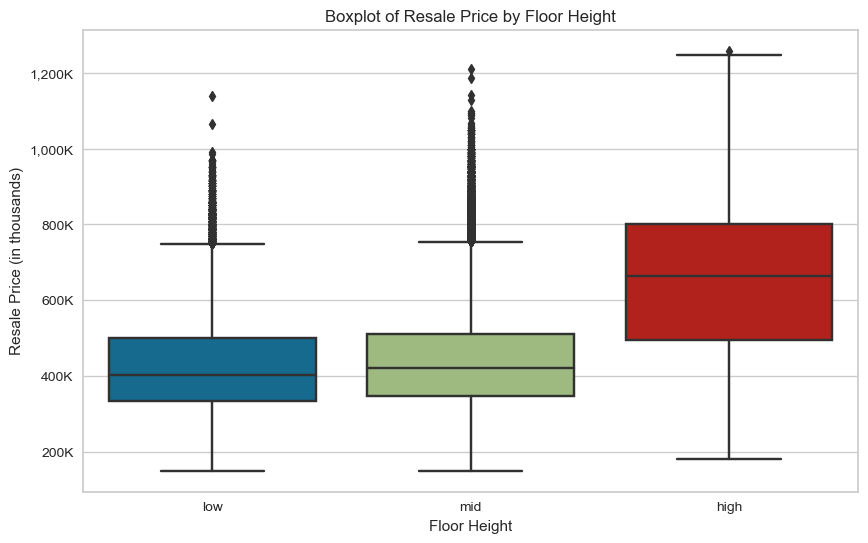

In [36]:
# Create a new column 'floor_height' based on the values in the 'floor_height_low', 'floor_height_mid' and 'floor_height_high' columns
housing_df['floor_height'] = housing_df.apply(
    lambda row: 'low' if row['floor_height_low'] == 1 else ('mid' if row['floor_height_mid'] == 1 else 'high'), axis=1)

# Create the boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='floor_height', y='resale_price', data= housing_df, order=['low', 'mid', 'high'])

# Define a function to format y-axis ticks
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K')

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Boxplot of Resale Price by Floor Height')
plt.xlabel('Floor Height')
plt.ylabel('Resale Price (in thousands)')
plt.show()

In [37]:
housing_df.head()

id tranc_yearmonth             town  flat_type block       street_name  \
0   88471         2016-05  kallang/whampoa     4_room    3b  upp_boon_keng_rd   
1  122598         2012-07           bishan     5_room   153      bishan_st_13   
2  170897         2013-07      bukit_batok  executive  289b    bt_batok_st_25   
3   86070         2012-04           bishan     4_room   232      bishan_st_22   
4  153632         2017-12           yishun     4_room   876      yishun_st_81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  resale_price  \
0     10_to_12            90.0     model_a                 2006      680000.0   
1     07_to_09           130.0    improved                 1987      665000.0   
2     13_to_15           144.0   apartment                 1997      838000.0   
3     01_to_05           103.0     model_a                 1992      550000.0   
4     01_to_03            83.0  simplified                 1987      298000.0   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2016            5          11     10     12   11   
1        2012            7           8      7      9    8   
2        2013            7          14     13     15   14   
3        2012            4           3      1      5    3   
4        2017           12           2      1      3    2   

        full_flat_type               address  floor_area_sqft  price_per_sqft  \
0       4_room_model_a  3b,_upp_boon_keng_rd          968.760      701.928238   
1      5_room_improved     153,_bishan_st_13         1399.320      475.230826   
2  executive_apartment  289b,_bt_batok_st_25         1550.016      540.639580   
3       4_room_model_a     232,_bishan_st_22         1108.692      496.080066   
4    4_room_simplified     876,_yishun_st_81          893.412      333.552717   

   hdb_age  max_floor_lvl  year_completed  residential  commercial  \
0       15             25            2005            1           0   
1       34              9            1987            1           0   
2       24             16            1996            1           0   
3       29             11            1990            1           1   
4       34              4            1987            1           0   

   market_hawker  multistorey_carpark  precinct_pavilion  \
0              0                    0                  0   
1              0                    0                  0   
2              0                    0                  0   
3              0                    0                  0   
4              0                    0                  0   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   142           0           0           0          96   
1                   112           0           0           0          56   
2                    90           0           0           0           0   
3                    75           0           0           0          68   
4                    48           0           0           0          30   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          46          0              0                      0             0   
1          56          0              0                      0             0   
2          30         60              0                      0             0   
3           7          0              0                      0             0   
4          18          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.314299   
1             0             0                  0  570153  1.346086   
2             0             0                  0  651289  1.343867   
3             0             0                  0  570232  1.358245   
4             0             0                  0  760876  1.414745   

    longitude planning_area  mall_nearest_di

## Exploratory Data Analysis (EDA)

In [38]:
housing_df.describe().T

count           mean            std  \
id                         150634.0   93047.887496   53679.906247   
floor_area_sqm             150634.0      97.197630      24.403040   
lease_commence_date        150634.0    1992.448464      12.138829   
resale_price               150634.0  449161.501213  143307.573143   
tranc_year                 150634.0    2016.489551       2.752396   
tranc_month                150634.0       6.580500       3.345468   
mid_storey                 150634.0       8.284823       5.508074   
lower                      150634.0       7.248370       5.515155   
upper                      150634.0       9.321275       5.507364   
mid                        150634.0       8.284823       5.508074   
floor_area_sqft            150634.0    1046.235290     262.674321   
price_per_sqft             150634.0     434.130280     104.797180   
hdb_age                    150634.0      28.551536      12.138829   
max_floor_lvl              150634.0      15.139816       6.232492   
year_completed             150634.0    1990.922906      12.202185   
residential                150634.0       1.000000       0.000000   
commercial                 150634.0       0.191318       0.393340   
market_hawker              150634.0       0.000100       0.009978   
multistorey_carpark        150634.0       0.000279       0.016696   
precinct_pavilion          150634.0       0.000896       0.029923   
total_dwelling_units       150634.0     124.683312      58.349670   
1room_sold                 150634.0       0.138813       5.947970   
2room_sold                 150634.0       1.782055      11.713826   
3room_sold                 150634.0      39.219366      68.748273   
4room_sold                 150634.0      50.083978      45.302101   
5room_sold                 150634.0      26.299853      33.456575   
exec_sold                  150634.0       5.940770      19.131872   
multigen_sold              150634.0       0.023972       1.135483   
studio_apartment_sold      150634.0       0.448564       5.350617   
1room_rental               150634.0       0.063678       2.028341   
2room_rental               150634.0       0.622516      11.193820   
3room_rental               150634.0       0.059409       0.669842   
other_room_rental          150634.0       0.000339       0.024305   
latitude                   150634.0       1.366224       0.042850   
longitude                  150634.0     103.839391       0.072506   
mall_nearest_distance      150634.0     660.584245     370.992108   
mall_within_500m           150634.0       0.487400       0.728508   
mall_within_1km            150634.0       1.786781       1.423342   
mall_within_2km            150634.0       5.169046       3.481453   
hawker_nearest_distance    150634.0    1173.700148    1076.701337   
hawker_within_500m         150634.0       0.488728       0.766323   
hawker_within_1km          150634.0       1.405639       1.710041   
hawker_within_2km          150634.0       3.792178       4.009034   
hawker_food_stalls         150634.0      48.652980      19.138780   
hawker_market_stalls       150634.0      58.138322      55.495519   
mrt_nearest_distance       150634.0     765.007872     429.366039   
bus_interchange            150634.0       0.546364       0.497847   
mrt_interchange            150634.0       0.264024       0.440814   
mrt_latitude               150634.0       1.365667       0.042563   
mrt_longitude              150634.0     103.839400       0.072582   
bus_stop_nearest_distance  150634.0     115.258966      55.572855   
bus_stop_latitude          150634.0       1.366231       0.042865   
bus_stop_longitude         150634.0     103.839369       0.072520   
pri_sch_nearest_distance   150634.0     395.172974     234.760931   
vacancy                    150634.0      55.368190      17.903918   
pri_sch_affiliation        150634.0       0.113195       0.316832   
pri_sch_latitude           150634.0       1.366268       0.042669   
pri_sch_longitude          1

### EDA 1 - Transaction Count by Year

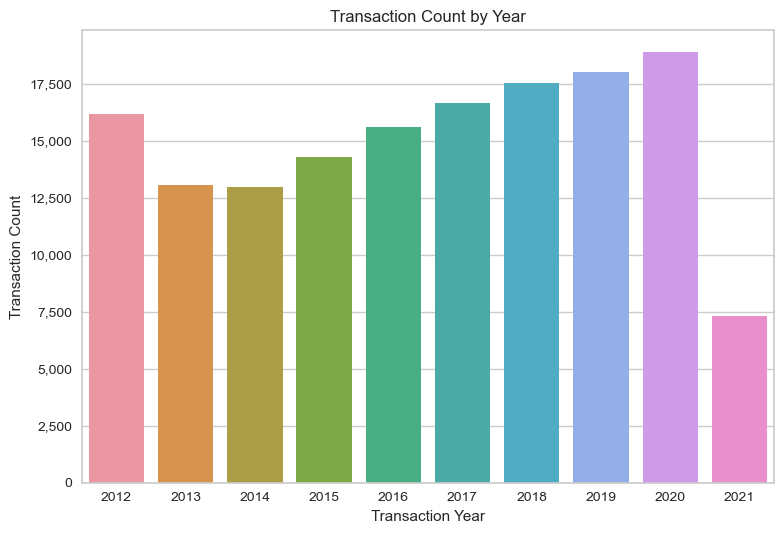

In [39]:
housing_df['tranc_year']=housing_df['tranc_year'].astype(int)

fig, ax=plt.subplots()
sns.countplot(data=housing_df, x='tranc_year')

plt.xlabel('Transaction Year')
plt.ylabel('Transaction Count')
plt.title('Transaction Count by Year')

# Format x-axis labels with comma separator
plt.gca().yaxis.set_major_formatter(lambda x, _: '{:,.0f}'.format(x))

plt.tight_layout()  # Optional, adjusts the spacing of the plot
plt.show()

The dip of transaction count of HDB resale flats  in the year of 2013 & 2014 is noted, and may be related to cooling measures introduced in 2013, including:
* Reduction of Loan-to-Value (LTV) limits
* Reduction of Mortgage Servicing Ratio (MSR) limits

2021 data is only up to April, if pro-rated for the year the transaction count  is on track to beat transaction count in 2020.


### EDA 2 - Relationship between Floor Area and Resale Price

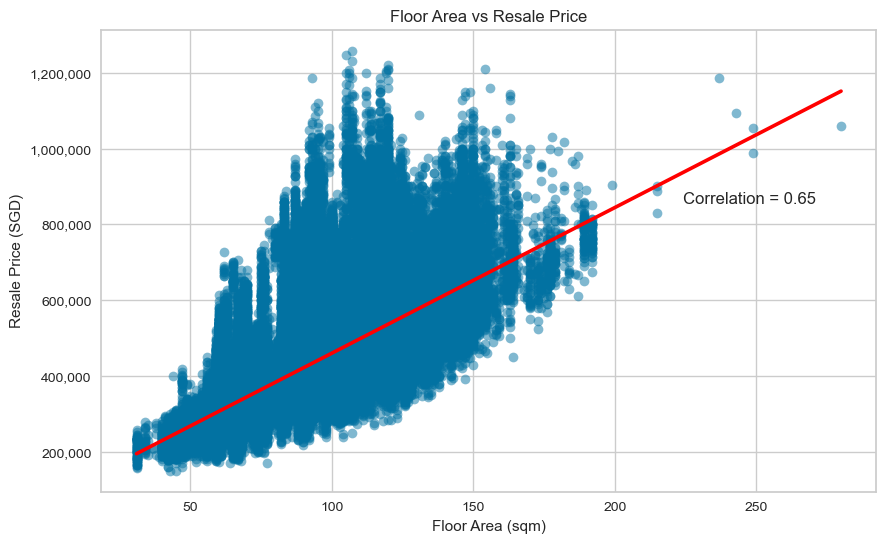

In [40]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(data=housing_df, x='floor_area_sqm', y='resale_price', scatter_kws={'alpha': 0.5},
                 line_kws={'color': 'red', 'zorder': 10})

# Format y-axis labels
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
ax.yaxis.set_major_formatter(formatter)

# Calculate correlation coefficient
corr_coeff = housing_df['floor_area_sqm'].corr(housing_df['resale_price'])

# Annotate correlation score on the chart
plt.annotate(f'Correlation = {corr_coeff:.2f}', xy=(0.75, 0.65), xycoords='axes fraction',
             fontsize=12, ha='left', va='top')

plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')
plt.title('Floor Area vs Resale Price')
plt.show()

Floor area of the resale flat seems to have a strong positive correlation to the resale price of the HDB unit. This is expected.

### EDA 3 - Relationship between Lease Left and Resale Price

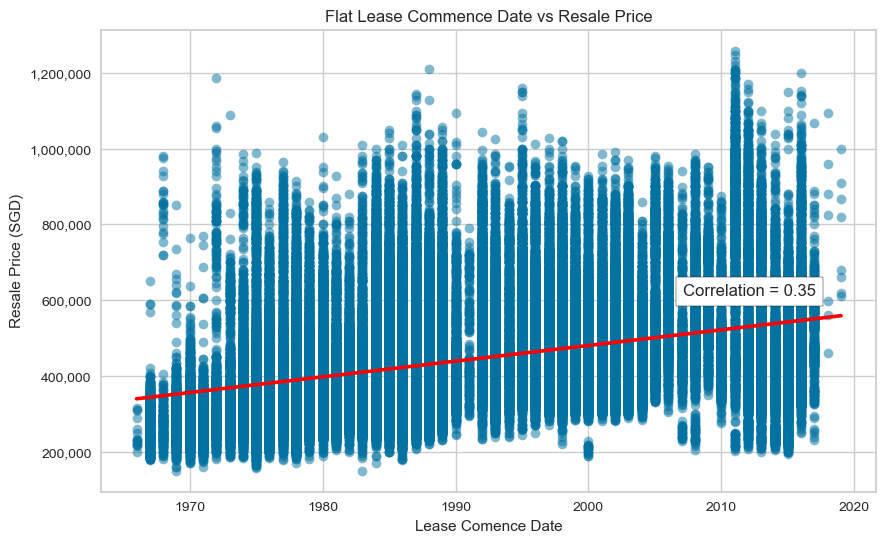

In [41]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(data=housing_df, x='lease_commence_date', y='resale_price', scatter_kws={'alpha': 0.5},
                 line_kws={'color': 'red', 'zorder': 10})

# Format y-axis labels
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
ax.yaxis.set_major_formatter(formatter)

# Calculate correlation coefficient
corr_coeff = housing_df['lease_commence_date'].corr(housing_df['resale_price'])

# Annotate correlation score on the chart
plt.annotate(f'Correlation = {corr_coeff:.2f}', xy=(0.75, 0.45), xycoords='axes fraction',
             fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black', pad=5))

plt.xlabel('Lease Comence Date')
plt.ylabel('Resale Price (SGD)')
plt.title('Flat Lease Commence Date vs Resale Price')
plt.show()

The more years left in the lease of the HDB unit is correlated to how high of a resale price the HDB unit is able to fetch.

### EDA 4 - Relationship between Total Dwelling Units and Resale Price

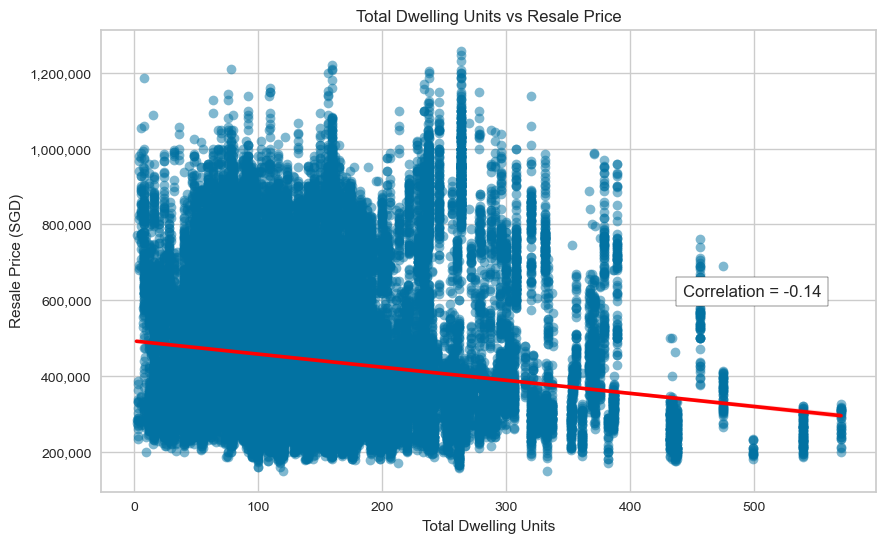

In [42]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(data=housing_df, x='total_dwelling_units', y='resale_price', scatter_kws={'alpha': 0.5},
                 line_kws={'color': 'red', 'zorder': 10})

# Format y-axis labels
formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
ax.yaxis.set_major_formatter(formatter)

# Calculate correlation coefficient
corr_coeff = housing_df['total_dwelling_units'].corr(housing_df['resale_price'])

# Annotate correlation score on the chart
plt.annotate(f'Correlation = {corr_coeff:.2f}', xy=(0.75, 0.45), xycoords='axes fraction',
             fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', edgecolor='black', pad=5))

plt.xlabel('Total Dwelling Units')
plt.ylabel('Resale Price (SGD)')
plt.title('Total Dwelling Units vs Resale Price')
plt.show()

Total dwelling units in a HDB block is observed to have a inverse correlation with the resale price. This is consistent with the expectation that higher density residential units tend to fetch a lower price.

### EDA 5 - Relationship between Town and Resale Price

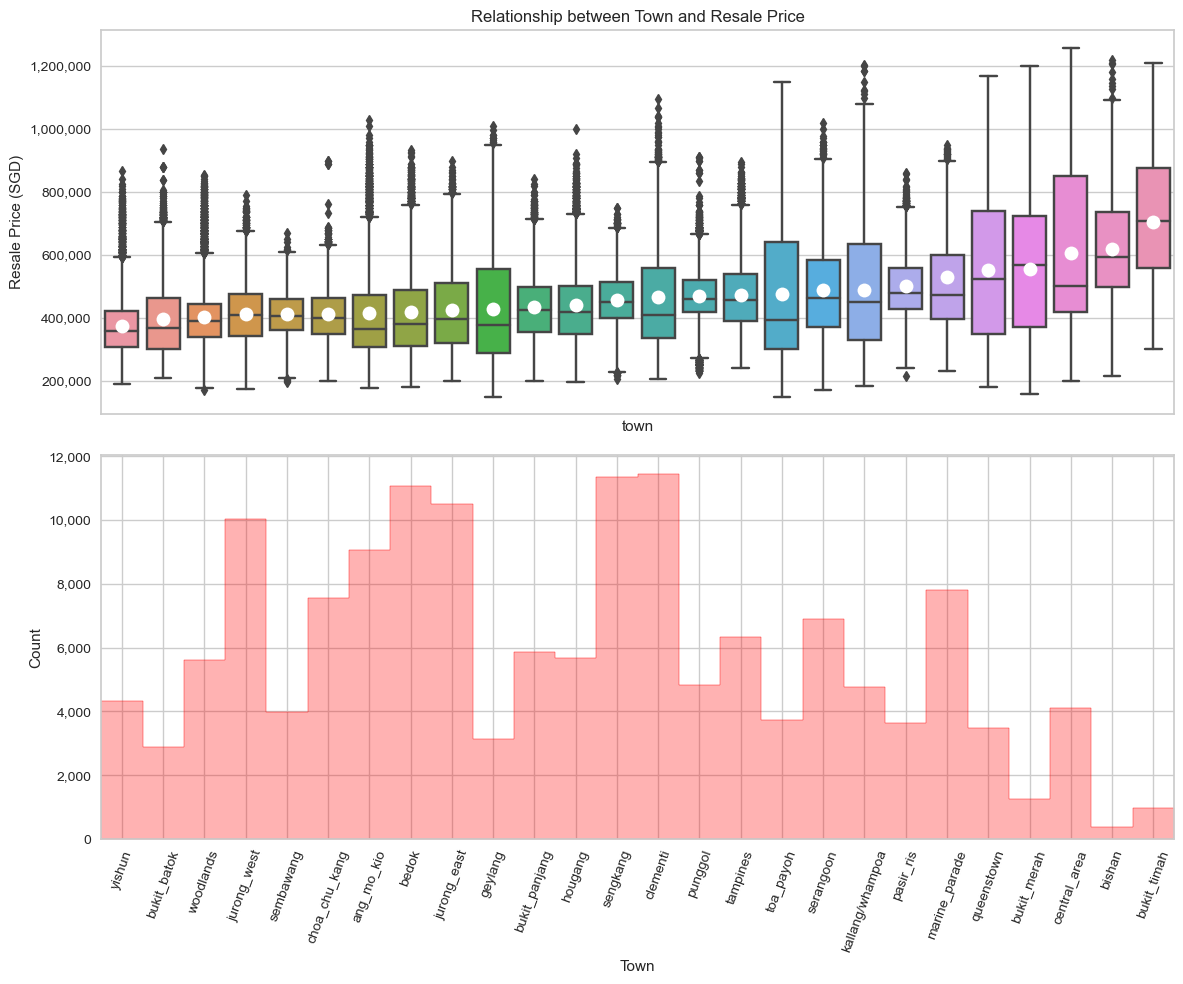

In [43]:
mean_prices=housing_df.groupby('town')['resale_price'].mean().sort_values()
fig, (ax_boxplot, ax_histogram) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Boxplot
sns.boxplot(data=housing_df, x='town', y='resale_price', order=mean_prices.index, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"}, ax=ax_boxplot)
ax_boxplot.set_ylabel('Resale Price (SGD)')
ax_boxplot.set_title('Relationship between Town and Resale Price')

# Histogram
sns.histplot(data=housing_df, x='town', ax=ax_histogram, color='red', alpha=0.3, bins=len(mean_prices.index), element='step', fill=True)
ax_histogram.set_ylabel('Count')

plt.xticks(rotation=70) 
plt.xlabel('Town')

formatter = ticker.StrMethodFormatter('{x:,.0f}')
ax_boxplot.yaxis.set_major_locator(ticker.FixedLocator(ax_boxplot.get_yticks()))
ax_boxplot.yaxis.set_major_formatter(formatter)
ax_histogram.yaxis.set_major_locator(ticker.FixedLocator(ax_histogram.get_yticks()))
ax_histogram.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

Most houses sold from 2012 to 2021 are in the OCR region, not so much within central region. Towns with the more expensive resale price had the lowest number of transactions (Bishan, Bukit Timah).

### EDA 6 - Histogram of Flats Sold in each Housing Region

In [44]:
# Investigating the number of flats sold in each housing region
sold_by_housing_region=housing_df.groupby('housing_region')
sold_by_housing_region.count()

id  tranc_yearmonth    town  flat_type   block  \
housing_region                                                       
CCR               2419             2419    2419       2419    2419   
OCR             111354           111354  111354     111354  111354   
RCR              36861            36861   36861      36861   36861   

                street_name  storey_range  floor_area_sqm  flat_model  \
housing_region                                                          
CCR                    2419          2419            2419        2419   
OCR                  111354        111354          111354      111354   
RCR                   36861         36861           36861       36861   

                lease_commence_date  resale_price  tranc_year  tranc_month  \
housing_region                                                               
CCR                            2419          2419        2419         2419   
OCR                          111354        111354      111354       111354   
RCR                           36861         36861       36861        36861   

                mid_storey   lower   upper     mid  full_flat_type  address  \
housing_region                                                                
CCR                   2419    2419    2419    2419            2419     2419   
OCR                 111354  111354  111354  111354          111354   111354   
RCR                  36861   36861   36861   36861           36861    36861   

                floor_area_sqft  price_per_sqft  hdb_age  max_floor_lvl  \
housing_region                                                            
CCR                        2419            2419     2419           2419   
OCR                      111354          111354   111354         111354   
RCR                       36861           36861    36861          36861   

                year_completed  residential  commercial  market_hawker  \
housing_region                                                           
CCR                       2419         2419        2419           2419   
OCR                     111354       111354      111354         111354   
RCR                      36861        36861       36861          36861   

                multistorey_carpark  precinct_pavilion  total_dwelling_units  \
housing_region                                                                 
CCR                            2419               2419                  2419   
OCR                          111354             111354                111354   
RCR                           36861              36861                 36861   

                1room_sold  2room_sold  3room_sold  4room_sold  5room_sold  \
housing_region                                                               
CCR                   2419        2419        2419        2419        2419   
OCR                 111354      111354      111354      111354      111354   
RCR                  36861       36861       36861       36861       36861   

                exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
housing_region                                                                  
CCR                  2419           2419                   2419          2419   
OCR                111354         111354                 111354        111354   
RCR                 36861          36861                  36861         36861   

                2room_rental  3room_rental  other_room_rental  postal  \
housing_region                                                          
CCR                     2419          2419               2419    2419   
OCR                   111354        111354             111354  111354   
RCR                    36861         36861              36861   36861   

                latitude  longitude  planning_area  mall_nearest_distance  \
housing_region                                                              
CCR                 2419       2419           2419 

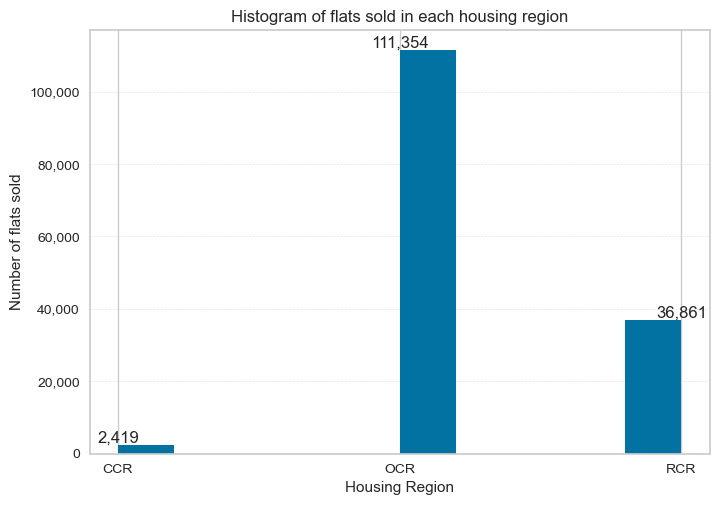

In [45]:
# Visualizing the number of flats sold in each housing region for this dataset
sold_by_housing_region=housing_df.groupby('housing_region')
counts = sold_by_housing_region.count()

plt.gca().yaxis.grid(True, linestyle='--', linewidth=0.5, zorder=1, alpha=0.5)
plt.hist(sold_by_housing_region.count().index, weights=sold_by_housing_region.count()['id'], zorder=2)
plt.gca().get_yaxis().set_major_formatter(lambda x, _: format(int(x), ','))
plt.gca().yaxis.grid(True)  # Show major y-axis gridlines

plt.xlabel('Housing Region')
plt.ylabel('Number of flats sold')
plt.title('Histogram of flats sold in each housing region')

for i, count in enumerate(counts['id']):
    label = '{:,.0f}'.format(count)
    plt.text(counts.index[i], count, label, ha='center', va='bottom')

plt.show()

Majority of the flats sold were in the OCR, followed by the RCR. There were only a small number of transactions in the CCR.

In [46]:
# Correlation between housing region and resale price
df_housing_region=housing_df[['resale_price', 'housing_region_CCR', 'housing_region_RCR', 'housing_region_OCR']]
df_housing_region.corr()

resale_price  housing_region_CCR  housing_region_RCR  \
resale_price            1.000000            0.142983            0.167698   
housing_region_CCR      0.142983            1.000000           -0.072717   
housing_region_RCR      0.167698           -0.072717            1.000000   
housing_region_OCR     -0.205143           -0.215099           -0.958365   

                    housing_region_OCR  
resale_price                 -0.205143  
housing_region_CCR           -0.215099  
housing_region_RCR           -0.958365  
housing_region_OCR            1.000000

Based on housing region alone, the correlation with resale price is not strong.
The worst performing variable is housing_region_CCR, presumably due to the smaller number of data points.

### Additional EDA for housing location with other variables

Create a df with housing regions and some other variables to:
 * Investigate correlation
 * Create interaction terms


In [47]:
# flat_type has 7 unique values
len(housing_df['flat_type'].unique().tolist())

7

### EDA 7 - Scatter Plot of Resale Price vs Flat Types

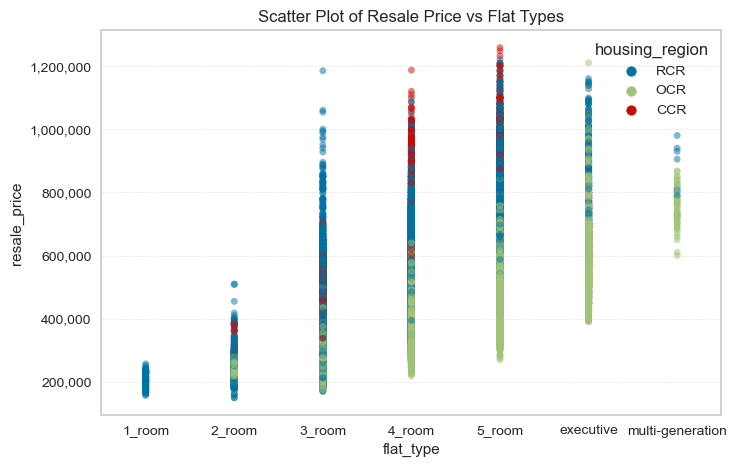

In [48]:
# Visualization of relationship between resale price and flat type for each housing region
plt.figure(figsize=(8, 5))
plt.gca().yaxis.grid(True, linestyle='--', linewidth=0.5, zorder=1, alpha=0.5)
sns.stripplot(data=housing_df, y="resale_price", x="flat_type", hue="housing_region",
                order=['1_room', '2_room', '3_room', '4_room', '5_room', 'executive', 'multi-generation'],
              alpha = 0.5, jitter=False)
plt.gca().get_yaxis().set_major_formatter(lambda x, _: format(int(x), ','))
plt.title('Scatter Plot of Resale Price vs Flat Types')
plt.show()

Where available, the price for each flat type in the CCR is mostly congregated at the top of the range of resale price.
Conversely, where available, the price for each flat type in the OCR is mostly congregated at the bottom of the range of resale price.

In [49]:
# Create a new housing_df called housing_df_location to investage correlations
housing_df_location=housing_df[['hdb_age', 'postal', 'postal_sector', 'housing_region', 'housing_region_CCR', 'housing_region_OCR', 'housing_region_RCR', 'resale_price', 'flat_type']]

In [50]:
# Get dummies for flat_type
flat_type_dummy=pd.get_dummies(housing_df_location['flat_type'])

In [51]:
# Concat dummies for flat type and housing_df_location
housing_df_location=pd.concat([housing_df_location, flat_type_dummy], axis=1)

In [52]:
housing_df_location

hdb_age  postal postal_sector housing_region  housing_region_CCR  \
0            15  382003            38            RCR                   0   
1            34  570153            57            RCR                   0   
2            24  651289            65            OCR                   0   
3            29  570232            57            RCR                   0   
4            34  760876            76            OCR                   0   
...         ...     ...           ...            ...                 ...   
150629       26  730849            73            OCR                   0   
150630       20  644648            64            OCR                   0   
150631       28  410639            41            RCR                   0   
150632       47  270032            27            CCR                   1   
150633       34  762666            76            OCR                   0   

        housing_region_OCR  housing_region_RCR  resale_price  \
0                        0                   1      680000.0   
1                        0                   1      665000.0   
2                        1                   0      838000.0   
3                        0                   1      550000.0   
4                        1                   0      298000.0   
...                    ...                 ...           ...   
150629                   1                   0      625000.0   
150630                   1                   0      455000.0   
150631                   0                   1      733000.0   
150632                   0                   0      338000.0   
150633                   1                   0      765000.0   

               flat_type  1_room  2_room  3_room  4_room  5_room  executive  \
0                 4_room       0       0       0       1       0          0   
1                 5_room       0       0       0       0       1          0   
2              executive       0       0       0       0       0          1   
3                 4_room       0       0       0       1       0          0   
4                 4_room       0       0       0       1       0          0   
...                  ...     ...     ...     ...     ...     ...        ...   
150629         executive       0       0       0       0       0          1   
150630            5_room       0       0       0       0       1          0   
150631         executive       0       0       0       0       0          1   
150632            3_room       0       0       1       0       0          0   
150633  multi-generation       0       0       0       0       0          0   

        multi-generation  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
...                  ...  
150629                 0  
150630                 0  
150631                 0  
150632                 0  
150633                 1  

[150634 rows x 16 columns]

In [53]:
# Create interaction term of housing_region * flat_type

for region_col in housing_df_location[['housing_region_CCR', 'housing_region_RCR', 'housing_region_OCR']]:
    for flat_type_col in housing_df_location[['1_room', '2_room', '3_room', '4_room', '5_room', 'executive', 'multi-generation']]:
        region_type=(region_col + '_' + flat_type_col).lower()
        housing_df_location[region_type]=housing_df_location[region_col]*housing_df_location[flat_type_col]

In [54]:
housing_df_location

hdb_age  postal postal_sector housing_region  housing_region_CCR  \
0            15  382003            38            RCR                   0   
1            34  570153            57            RCR                   0   
2            24  651289            65            OCR                   0   
3            29  570232            57            RCR                   0   
4            34  760876            76            OCR                   0   
...         ...     ...           ...            ...                 ...   
150629       26  730849            73            OCR                   0   
150630       20  644648            64            OCR                   0   
150631       28  410639            41            RCR                   0   
150632       47  270032            27            CCR                   1   
150633       34  762666            76            OCR                   0   

        housing_region_OCR  housing_region_RCR  resale_price  \
0                        0                   1      680000.0   
1                        0                   1      665000.0   
2                        1                   0      838000.0   
3                        0                   1      550000.0   
4                        1                   0      298000.0   
...                    ...                 ...           ...   
150629                   1                   0      625000.0   
150630                   1                   0      455000.0   
150631                   0                   1      733000.0   
150632                   0                   0      338000.0   
150633                   1                   0      765000.0   

               flat_type  1_room  2_room  3_room  4_room  5_room  executive  \
0                 4_room       0       0       0       1       0          0   
1                 5_room       0       0       0       0       1          0   
2              executive       0       0       0       0       0          1   
3                 4_room       0       0       0       1       0          0   
4                 4_room       0       0       0       1       0          0   
...                  ...     ...     ...     ...     ...     ...        ...   
150629         executive       0       0       0       0       0          1   
150630            5_room       0       0       0       0       1          0   
150631         executive       0       0       0       0       0          1   
150632            3_room       0       0       1       0       0          0   
150633  multi-generation       0       0       0       0       0          0   

        multi-generation  housing_region_ccr_1_room  \
0                      0                          0   
1                      0                          0   
2                      0                          0   
3                      0                          0   
4                      0                          0   
...                  ...                        ...   
150629                 0                          0   
150630                 0                          0   
150631                 0                          0   
150632                 0                          0   
150633                 1                          0   

        housing_region_ccr_2_room  housing_region_ccr_3_room  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
...                           ...                        ...   
150629                          0                          0   
150630                          0                          0   
150631                          0                          0   
150632                          0                          1   
150633      

In [55]:
housing_df_location_corr=housing_df_location.iloc[:, [7] + list(range(-21,0))]

In [56]:
housing_df_location_corr

resale_price  housing_region_ccr_1_room  housing_region_ccr_2_room  \
0           680000.0                          0                          0   
1           665000.0                          0                          0   
2           838000.0                          0                          0   
3           550000.0                          0                          0   
4           298000.0                          0                          0   
...              ...                        ...                        ...   
150629      625000.0                          0                          0   
150630      455000.0                          0                          0   
150631      733000.0                          0                          0   
150632      338000.0                          0                          0   
150633      765000.0                          0                          0   

        housing_region_ccr_3_room  housing_region_ccr_4_room  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
...                           ...                        ...   
150629                          0                          0   
150630                          0                          0   
150631                          0                          0   
150632                          1                          0   
150633                          0                          0   

        housing_region_ccr_5_room  housing_region_ccr_executive  \
0                               0                             0   
1                               0                             0   
2                               0                             0   
3                               0                             0   
4                               0                             0   
...                           ...                           ...   
150629                          0                             0   
150630                          0                             0   
150631                          0                             0   
150632                          0                             0   
150633                          0                             0   

        housing_region_ccr_multi-generation  housing_region_rcr_1_room  \
0                                         0                          0   
1                                         0                          0   
2                                         0                          0   
3                                         0                          0   
4                                         0                          0   
...                                     ...                        ...   
150629                                    0                          0   
150630                                    0                          0   
150631                                    0                          0   
150632                                    0                          0   
150633                                    0                          0   

        housing_region_rcr_2_room  housing_region_rcr_3_room  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   
...                           ...                        ...   
150629                          0                          0   
150630                          0                          0   
150631                          

### EDA 8 - Heatmap of Housing Price vs Housing Region + Flat Type

For more information over [CCR, RCR and OCR](#Working-with-postal-code), we may refer to here.

<Axes: >

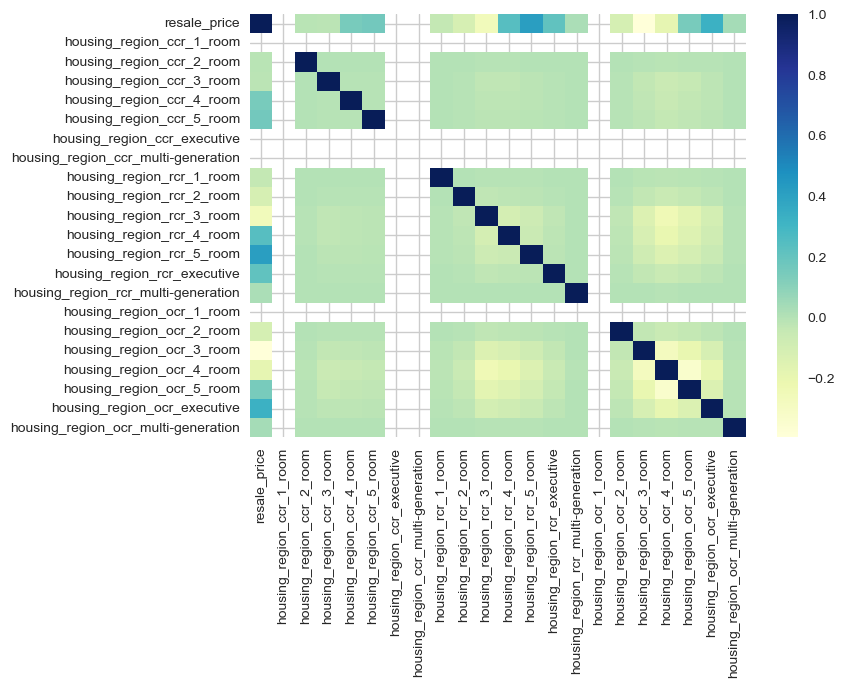

In [57]:
sns.heatmap(housing_df_location_corr.corr(), cmap="YlGnBu")

In [58]:
# Add the newly created regional flat type into housing_df
housing_df = housing_df.reset_index(drop=True)
housing_df_location_corr = housing_df_location_corr.reset_index(drop=True)
housing_df = housing_df.join(housing_df_location_corr.drop('resale_price', axis=1))

In [59]:
housing_df.head()

id tranc_yearmonth             town  flat_type block       street_name  \
0   88471         2016-05  kallang/whampoa     4_room    3b  upp_boon_keng_rd   
1  122598         2012-07           bishan     5_room   153      bishan_st_13   
2  170897         2013-07      bukit_batok  executive  289b    bt_batok_st_25   
3   86070         2012-04           bishan     4_room   232      bishan_st_22   
4  153632         2017-12           yishun     4_room   876      yishun_st_81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  resale_price  \
0     10_to_12            90.0     model_a                 2006      680000.0   
1     07_to_09           130.0    improved                 1987      665000.0   
2     13_to_15           144.0   apartment                 1997      838000.0   
3     01_to_05           103.0     model_a                 1992      550000.0   
4     01_to_03            83.0  simplified                 1987      298000.0   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2016            5          11     10     12   11   
1        2012            7           8      7      9    8   
2        2013            7          14     13     15   14   
3        2012            4           3      1      5    3   
4        2017           12           2      1      3    2   

        full_flat_type               address  floor_area_sqft  price_per_sqft  \
0       4_room_model_a  3b,_upp_boon_keng_rd          968.760      701.928238   
1      5_room_improved     153,_bishan_st_13         1399.320      475.230826   
2  executive_apartment  289b,_bt_batok_st_25         1550.016      540.639580   
3       4_room_model_a     232,_bishan_st_22         1108.692      496.080066   
4    4_room_simplified     876,_yishun_st_81          893.412      333.552717   

   hdb_age  max_floor_lvl  year_completed  residential  commercial  \
0       15             25            2005            1           0   
1       34              9            1987            1           0   
2       24             16            1996            1           0   
3       29             11            1990            1           1   
4       34              4            1987            1           0   

   market_hawker  multistorey_carpark  precinct_pavilion  \
0              0                    0                  0   
1              0                    0                  0   
2              0                    0                  0   
3              0                    0                  0   
4              0                    0                  0   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   142           0           0           0          96   
1                   112           0           0           0          56   
2                    90           0           0           0           0   
3                    75           0           0           0          68   
4                    48           0           0           0          30   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          46          0              0                      0             0   
1          56          0              0                      0             0   
2          30         60              0                      0             0   
3           7          0              0                      0             0   
4          18          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.314299   
1             0             0                  0  570153  1.346086   
2             0             0                  0  651289  1.343867   
3             0             0                  0  570232  1.358245   
4             0             0                  0  760876  1.414745   

    longitude planning_area  mall_nearest_di

In [60]:
name_dict = {}
# loop thru the columns names of housing_df and correct the name by replacing spaces & '-' with '_'
for name in housing_df.columns:
    name_dict[name] = name.replace('-','_')
# Correct the column names with the dict
housing_df.rename(columns=name_dict,inplace=True)
housing_df.head()

id tranc_yearmonth             town  flat_type block       street_name  \
0   88471         2016-05  kallang/whampoa     4_room    3b  upp_boon_keng_rd   
1  122598         2012-07           bishan     5_room   153      bishan_st_13   
2  170897         2013-07      bukit_batok  executive  289b    bt_batok_st_25   
3   86070         2012-04           bishan     4_room   232      bishan_st_22   
4  153632         2017-12           yishun     4_room   876      yishun_st_81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  resale_price  \
0     10_to_12            90.0     model_a                 2006      680000.0   
1     07_to_09           130.0    improved                 1987      665000.0   
2     13_to_15           144.0   apartment                 1997      838000.0   
3     01_to_05           103.0     model_a                 1992      550000.0   
4     01_to_03            83.0  simplified                 1987      298000.0   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2016            5          11     10     12   11   
1        2012            7           8      7      9    8   
2        2013            7          14     13     15   14   
3        2012            4           3      1      5    3   
4        2017           12           2      1      3    2   

        full_flat_type               address  floor_area_sqft  price_per_sqft  \
0       4_room_model_a  3b,_upp_boon_keng_rd          968.760      701.928238   
1      5_room_improved     153,_bishan_st_13         1399.320      475.230826   
2  executive_apartment  289b,_bt_batok_st_25         1550.016      540.639580   
3       4_room_model_a     232,_bishan_st_22         1108.692      496.080066   
4    4_room_simplified     876,_yishun_st_81          893.412      333.552717   

   hdb_age  max_floor_lvl  year_completed  residential  commercial  \
0       15             25            2005            1           0   
1       34              9            1987            1           0   
2       24             16            1996            1           0   
3       29             11            1990            1           1   
4       34              4            1987            1           0   

   market_hawker  multistorey_carpark  precinct_pavilion  \
0              0                    0                  0   
1              0                    0                  0   
2              0                    0                  0   
3              0                    0                  0   
4              0                    0                  0   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   142           0           0           0          96   
1                   112           0           0           0          56   
2                    90           0           0           0           0   
3                    75           0           0           0          68   
4                    48           0           0           0          30   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          46          0              0                      0             0   
1          56          0              0                      0             0   
2          30         60              0                      0             0   
3           7          0              0                      0             0   
4          18          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.314299   
1             0             0                  0  570153  1.346086   
2             0             0                  0  651289  1.343867   
3             0             0                  0  570232  1.358245   
4             0             0                  0  760876  1.414745   

    longitude planning_area  mall_nearest_di

### EDA 9 - Correlation Analysis between Resale Price and Other Variables 
### (Table of Correlation Coefficients, Heatmaps and Pairplots)



In [61]:
def get_correlations(data, correlation_threshold):
    # Sort by resale_price and bring it to first column
    corr_chart = (data.corr().sort_values(by='resale_price',ascending=False))
    resale_price = corr_chart.pop("resale_price")
    corr_chart.insert(0, "resale_price", resale_price)
    
    print('Full Correlation Table')
    display(corr_chart)

    # Only showing abs(values) that are greater than the correlation_threshold inputted
    corr_chart_threshold = corr_chart[abs(corr_chart['resale_price'])>correlation_threshold]
    corr_chart_threshold = corr_chart_threshold.loc[:,corr_chart_threshold.index]
    
    print(f'Correlation Table for |coeff|<{correlation_threshold}:')
    display(corr_chart_threshold)
    

    # Creating 2 heatmaps
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # Plot the first heatmap for features above corr coeff threshold
    sns.heatmap(corr_chart_threshold, annot=True, ax=axes[0], cmap='coolwarm', center=0)
    axes[0].set_title(f'Heatmap for features above corr coeff threshold {correlation_threshold}')

    # Plot the second heatmap for resale_price only
    sns.heatmap(corr_chart_threshold[['resale_price']], annot=True, ax=axes[1], cmap='coolwarm', center=0)
    axes[1].set_title(f'Heatmap for resale_price only (>{correlation_threshold})')

    plt.tight_layout()
    plt.show()
    
    # Shows only first 100 rows, if not it will take a very long time to plot
    sns.pairplot(data.loc[:100,corr_chart_threshold.index] )
    
    return corr_chart_threshold

Full Correlation Table


resale_price  floor_area_sqm  lease_commence_date  \
resale_price                   1.000000        0.654120             0.350337   
floor_area_sqm                 0.654120        1.000000             0.283182   
max_floor_lvl                  0.495650        0.073098             0.458348   
5room_sold                     0.359434        0.391143             0.332575   
year_completed                 0.353698        0.288671             0.988912   
mid                            0.353213        0.023855             0.265112   
lease_commence_date            0.350337        0.283182             1.000000   
exec_sold                      0.337500        0.512606             0.044453   
hawker_within_2km              0.183168       -0.292913            -0.407918   
housing_region_RCR             0.167698       -0.255050            -0.333160   
housing_region_CCR             0.142983       -0.075591            -0.040126   
sec_sch_longitude              0.108911       -0.009090            -0.006985   
mall_within_2km                0.108648       -0.060319             0.000668   
pri_sch_longitude              0.106681       -0.009764            -0.009005   
mrt_longitude                  0.106506       -0.013885            -0.007962   
bus_stop_longitude             0.106394       -0.012127            -0.007886   
sec_sch_nearest_dist           0.095339       -0.063315            -0.070921   
4room_sold                     0.092600       -0.067950             0.285400   
hawker_within_1km              0.090516       -0.328017            -0.412577   
mall_within_500m               0.085151        0.067526             0.073281   
mall_within_1km                0.078815        0.041818             0.066120   
mrt_interchange                0.066413        0.075549             0.265905   
studio_apartment_sold          0.040312       -0.050890             0.140585   
multigen_sold                  0.037406        0.043909            -0.009338   
cutoff_point                   0.034572       -0.077721            -0.060264   
bus_stop_nearest_distance      0.031940        0.006461            -0.034772   
pri_sch_affiliation            0.030931       -0.042265            -0.119898   
other_room_rental              0.013049        0.000447             0.010039   
hawker_within_500m             0.012637       -0.312530            -0.377420   
bus_interchange                0.002547        0.053887             0.241911   
affiliation                   -0.000466       -0.083810            -0.091333   
tranc_month                   -0.006823        0.003735            -0.000737   
hawker_market_stalls          -0.009378       -0.206241            -0.373966   
pri_sch_nearest_distance      -0.011004       -0.113645            -0.181359   
hawker_nearest_distance       -0.014537        0.206886             0.503202   
vacancy                       -0.016140       -0.029813             0.167118   
tranc_year                    -0.019146        0.021400             0.204991   
hawker_food_stalls            -0.033581       -0.061116            -0.133437   
1room_rental                  -0.037993       -0.058999             0.001397   
1room_sold                    -0.039434       -0.063309            -0.033546   
pop_ranking                   -0.057766       -0.030381            -0.018210   
2room_rental                  -0.077548       -0.112918            -0.074427   
3room_rental                  -0.079965       -0.110405            -0.108907   
mall_nearest_distance         -0.092239       -0.102776            -0.278568   
mrt_nearest_distance          -0.128222        0.053186             0.154657   
total_dwelling_units          -0.140725       -0.434511            -0.154468   
2room_sold                    -0.145287       -0.241249             0.047014   
housing_region_OCR            -0.205143        0.271383             0.337714   
pri_sch_latitude              -0.214707        0.217131             0.366473   
mrt_latitude               

Correlation Table for |coeff|<0.3:


resale_price  floor_area_sqm  max_floor_lvl  5room_sold  \
resale_price             1.000000        0.654120       0.495650    0.359434   
floor_area_sqm           0.654120        1.000000       0.073098    0.391143   
max_floor_lvl            0.495650        0.073098       1.000000    0.399125   
5room_sold               0.359434        0.391143       0.399125    1.000000   
year_completed           0.353698        0.288671       0.464696    0.336873   
mid                      0.353213        0.023855       0.556540    0.215740   
lease_commence_date      0.350337        0.283182       0.458348    0.332575   
exec_sold                0.337500        0.512606      -0.042582   -0.160837   
3room_sold              -0.410368       -0.585996      -0.098646   -0.400053   

                     year_completed       mid  lease_commence_date  exec_sold  \
resale_price               0.353698  0.353213             0.350337   0.337500   
floor_area_sqm             0.288671  0.023855             0.283182   0.512606   
max_floor_lvl              0.464696  0.556540             0.458348  -0.042582   
5room_sold                 0.336873  0.215740             0.332575  -0.160837   
year_completed             1.000000  0.268373             0.988912   0.042357   
mid                        0.268373  1.000000             0.265112  -0.042873   
lease_commence_date        0.988912  0.265112             1.000000   0.044453   
exec_sold                  0.042357 -0.042873             0.044453   1.000000   
3room_sold                -0.494684 -0.041794            -0.496150  -0.162612   

                     3room_sold  
resale_price          -0.410368  
floor_area_sqm        -0.585996  
max_floor_lvl         -0.098646  
5room_sold            -0.400053  
year_completed        -0.494684  
mid                   -0.041794  
lease_commence_date   -0.496150  
exec_sold             -0.162612  
3room_sold             1.000000

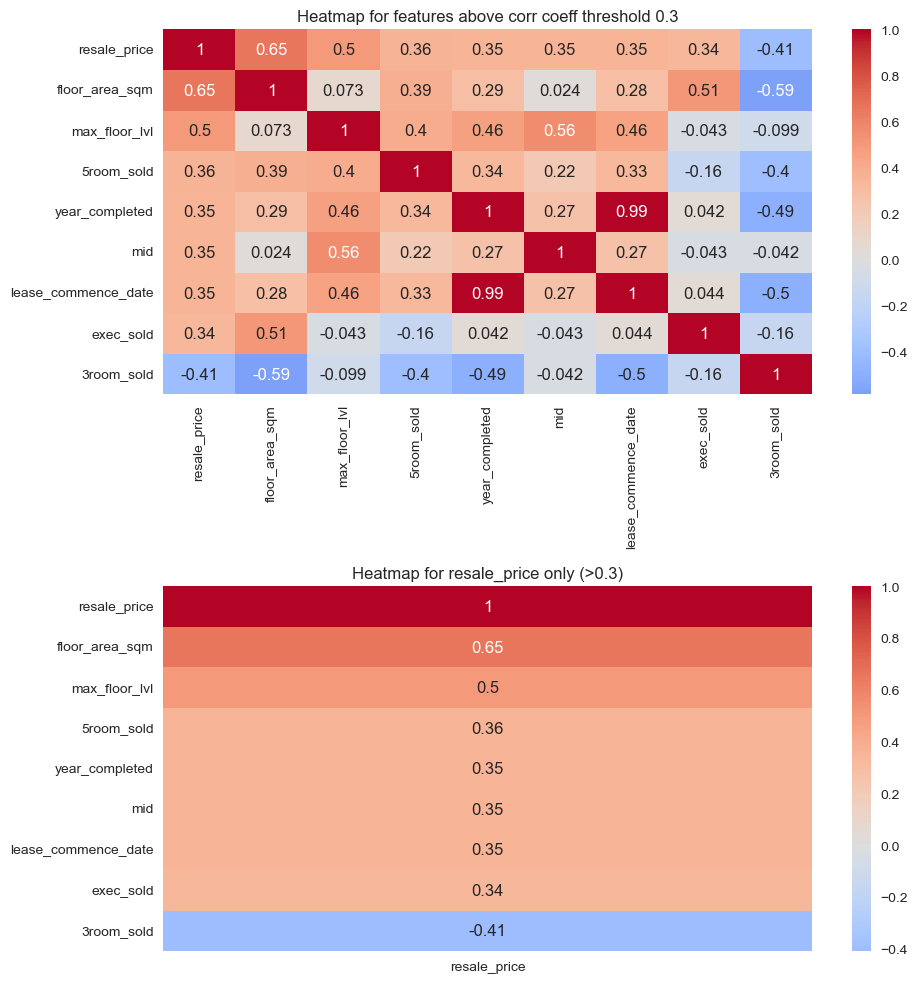

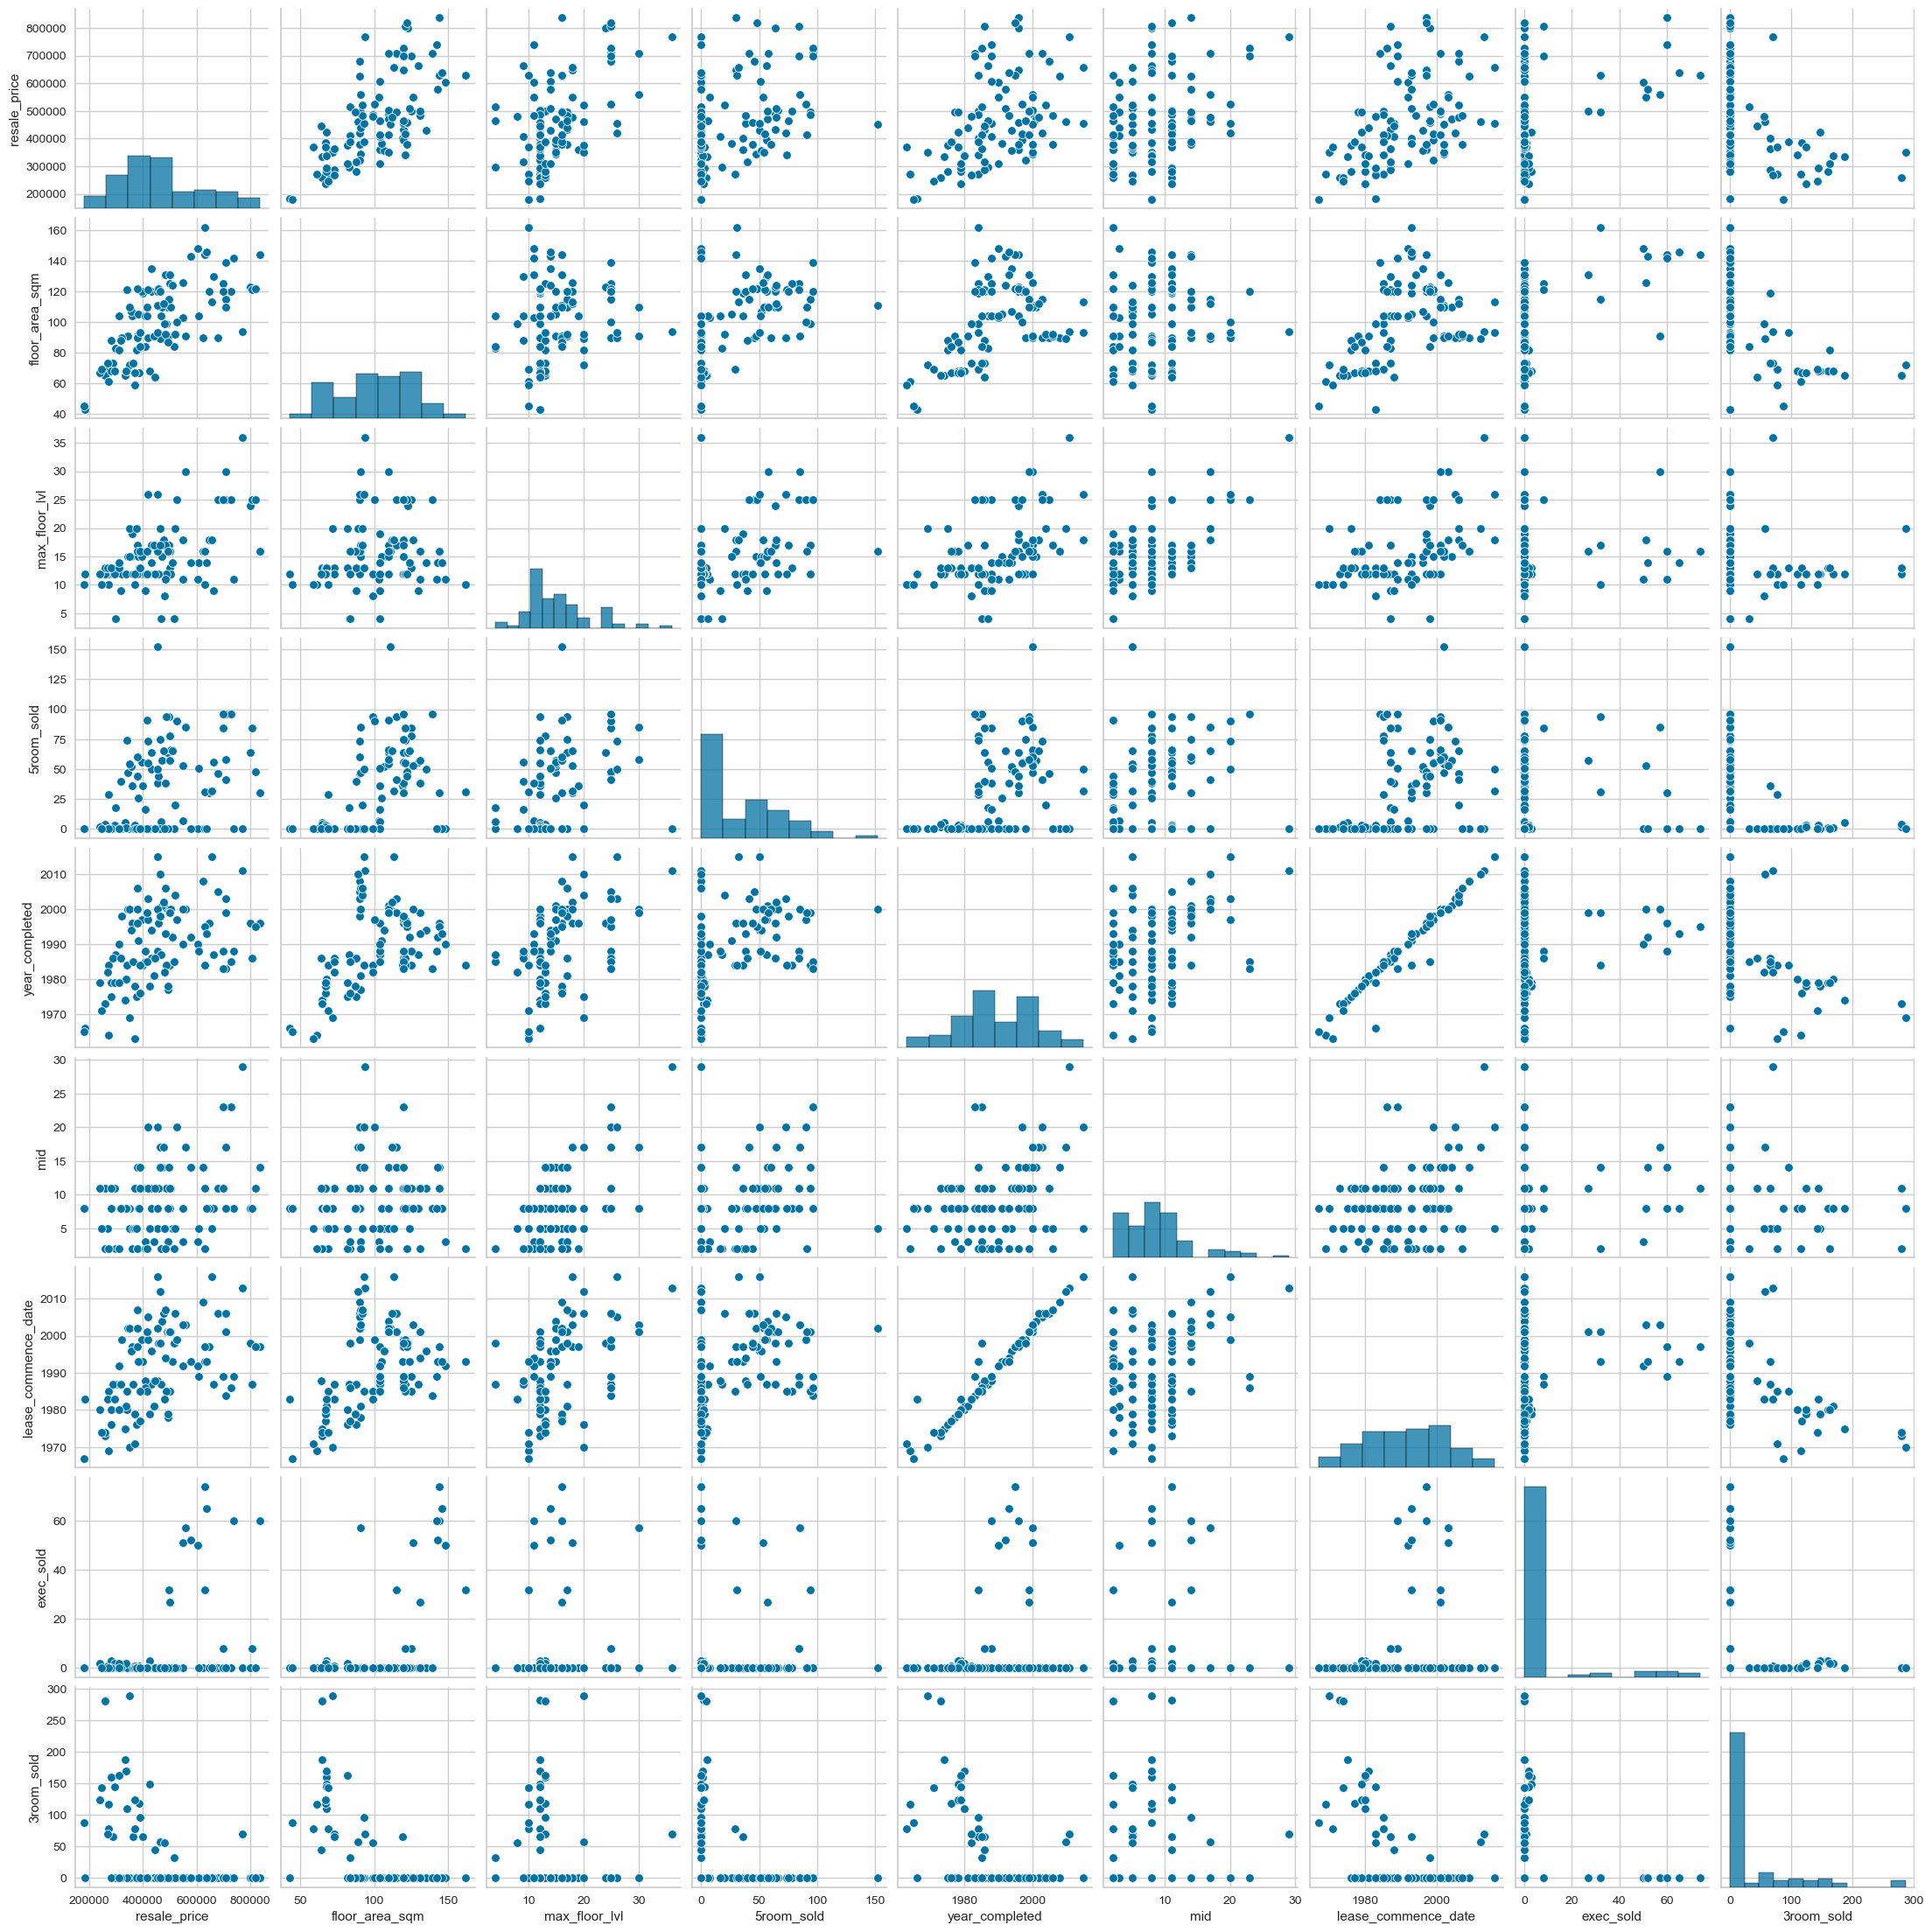

In [62]:
corr_thres = get_correlations(num_with_otherprop_and_prirank, 0.3)

### EDA 10 - Scatter Plot of Primary School Ranking vs Resale Price with Nearest Distance

C:\Users\LENOVO YOGA CORE I5\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


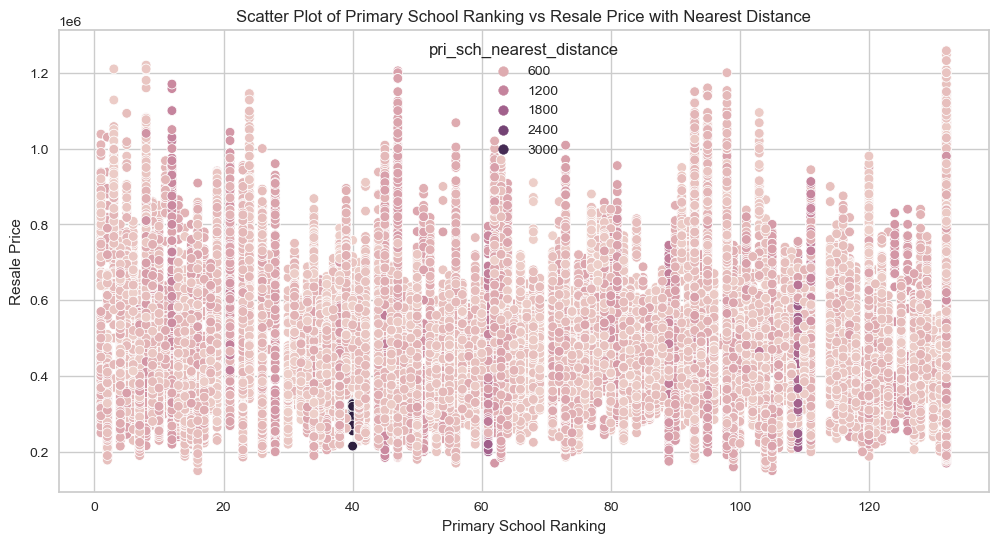

In [63]:
# Extract the columns for x-axis, y-axis, and hue
x = num_with_otherprop_and_prirank['pop_ranking']
y = num_with_otherprop_and_prirank['resale_price']
hue = num_with_otherprop_and_prirank['pri_sch_nearest_distance']

plt.figure(figsize=(12, 6))

sns.scatterplot(x=x, y=y, hue=hue)

plt.title('Scatter Plot of Primary School Ranking vs Resale Price with Nearest Distance')
plt.xlabel('Primary School Ranking')
plt.ylabel('Resale Price')

plt.show()

There is no obvious correlation between resale price and primary school ranking (corr coeff=-0.057680). No observable correlation for pri_sch_nearest_distance too. 

### EDA 11 - Scatter Plot of Primary School Ranking vs Mean Resale Price with Error Bar (SD)

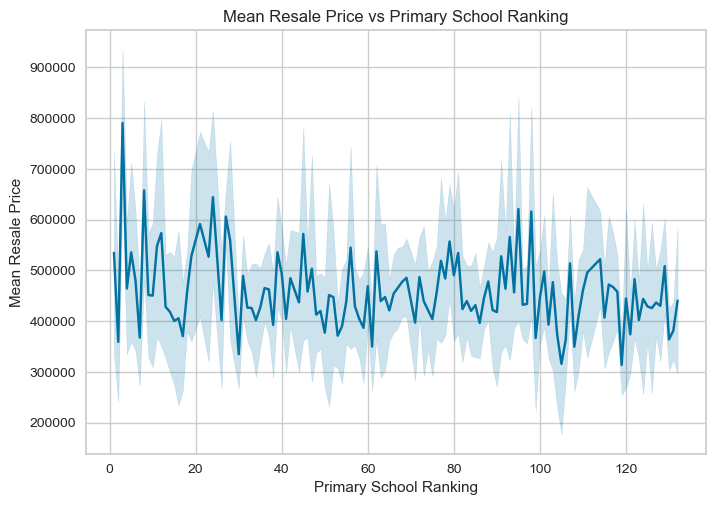

In [64]:
sns.lineplot(x='pop_ranking', y='resale_price', data=num_with_otherprop_and_prirank, errorbar='sd')

# Set plot title and labels
plt.title('Mean Resale Price vs Primary School Ranking')
plt.xlabel('Primary School Ranking')
plt.ylabel('Mean Resale Price')

# Display the line plot with error bars
plt.show()


After aggregating the values for every ranking, there is still no obvious trend, as seen above.
- An attempt was made to split the ranking into 2 categories instead. To decide on the threshold to separate the 2 groups of rankings, the test_score of all possible thresholds are compared. The results show that the optimal ranking is 8, which increases the test_Score by 0.002.

In [65]:
# Separating the school rankings into 2 categories. Rank 8 and above will be mapped to Rank 1 and the rest will be mapped to Rank 2.

pri_ranking['pop_ranking_2cat'] = pri_ranking['pop_ranking'].map(lambda x: 1 if x <= 8 else 2)
pri_ranking.head()

pri_sch_name  pop_ranking  pop_ranking_2cat
0               geylang_methodist_school          111                 2
1  kuo_chuan_presbyterian_primary_school           24                 2
2                  keming_primary_school           44                 2
3                   catholic_high_school            8                 1
4              naval_base_primary_school          115                 2

In [66]:
pri_ranking

pri_sch_name  pop_ranking  pop_ranking_2cat
0                    geylang_methodist_school          111                 2
1       kuo_chuan_presbyterian_primary_school           24                 2
2                       keming_primary_school           44                 2
3                        catholic_high_school            8                 1
4                   naval_base_primary_school          115                 2
...                                       ...          ...               ...
150629               evergreen_primary_school          102                 2
150630             jurong_west_primary_school           94                 2
150631                      maha_bodhi_school           52                 2
150632                new_town_primary_school          132                 2
150633               northland_primary_school           34                 2

[150634 rows x 3 columns]

In [67]:
# Adding the Popularity ranking into housing_df
housing_df = housing_df.join(pri_ranking[['pop_ranking','pop_ranking_2cat']])

In [68]:
housing_df.head()

id tranc_yearmonth             town  flat_type block       street_name  \
0   88471         2016-05  kallang/whampoa     4_room    3b  upp_boon_keng_rd   
1  122598         2012-07           bishan     5_room   153      bishan_st_13   
2  170897         2013-07      bukit_batok  executive  289b    bt_batok_st_25   
3   86070         2012-04           bishan     4_room   232      bishan_st_22   
4  153632         2017-12           yishun     4_room   876      yishun_st_81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  resale_price  \
0     10_to_12            90.0     model_a                 2006      680000.0   
1     07_to_09           130.0    improved                 1987      665000.0   
2     13_to_15           144.0   apartment                 1997      838000.0   
3     01_to_05           103.0     model_a                 1992      550000.0   
4     01_to_03            83.0  simplified                 1987      298000.0   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2016            5          11     10     12   11   
1        2012            7           8      7      9    8   
2        2013            7          14     13     15   14   
3        2012            4           3      1      5    3   
4        2017           12           2      1      3    2   

        full_flat_type               address  floor_area_sqft  price_per_sqft  \
0       4_room_model_a  3b,_upp_boon_keng_rd          968.760      701.928238   
1      5_room_improved     153,_bishan_st_13         1399.320      475.230826   
2  executive_apartment  289b,_bt_batok_st_25         1550.016      540.639580   
3       4_room_model_a     232,_bishan_st_22         1108.692      496.080066   
4    4_room_simplified     876,_yishun_st_81          893.412      333.552717   

   hdb_age  max_floor_lvl  year_completed  residential  commercial  \
0       15             25            2005            1           0   
1       34              9            1987            1           0   
2       24             16            1996            1           0   
3       29             11            1990            1           1   
4       34              4            1987            1           0   

   market_hawker  multistorey_carpark  precinct_pavilion  \
0              0                    0                  0   
1              0                    0                  0   
2              0                    0                  0   
3              0                    0                  0   
4              0                    0                  0   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   142           0           0           0          96   
1                   112           0           0           0          56   
2                    90           0           0           0           0   
3                    75           0           0           0          68   
4                    48           0           0           0          30   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          46          0              0                      0             0   
1          56          0              0                      0             0   
2          30         60              0                      0             0   
3           7          0              0                      0             0   
4          18          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.314299   
1             0             0                  0  570153  1.346086   
2             0             0                  0  651289  1.343867   
3             0             0                  0  570232  1.358245   
4             0             0                  0  760876  1.414745   

    longitude planning_area  mall_nearest_di

### Patsy & Yellowbrick Prediction Error Analysis

Using Patsy & Yellowbrick, create 3 **functions** for quick and easy feature testing with prediction error plot.

In [69]:
def split_train_and_test (X, y):
    # split the data into train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Squeeze 1 dimensional axis objects into scalar
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()
    return X_train, X_test, y_train, y_test

def plot_equation (data: pd.DataFrame, equation: str):
    # Create the X & y
    outcome, predictors = dmatrices(equation, data=data)
    
    # split the data into train & test
    X_train, X_test, y_train, y_test = split_train_and_test(predictors, outcome)
    
    # Instantiate the 3 models (Linear Regression, ridge & lasso)
    lr = LinearRegression()
    ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))
    lasso = LassoCV(n_alphas=200)
    
    # Visualise the prediction error plot (unhide to see plot for Ridge & Lasso)
    visualizer_lr = prediction_error(lr, X_train, y_train, X_test, y_test, alpha=0.4)
#     visualizer_lasso = prediction_error(ridge, X_train, y_train, X_test, y_test, alpha=0.4)
#     visualizer_ridge = prediction_error(lasso, X_train, y_train, X_test, y_test, alpha=0.4)
    
    # Display the R2 score & RMSE
    display_R2_RMSE('Linear Regression', lr, X_train, X_test, y_train, y_test)
    display_R2_RMSE('Ridge', ridge, X_train, X_test, y_train, y_test)
    display_R2_RMSE('Lasso', lasso, X_train, X_test, y_train, y_test)
    
def display_R2_RMSE (model_name:str, model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make prediction
    y_pred = model.predict(X_test)
    
    print(model_name)
    print(f'R2 (train): {model.score(X_train, y_train)}')
    print(f'R2 (test): {model.score(X_test, y_test)}')
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
    print('-----------------------------------------------------\n')

**Patsy Run for Model 1**:<br>

**For this prediction error analysis, the feature selection are based on domain knowledge of the elements that are known to affect housing prices.**

In [70]:
# List of categorical features to encode and numerical features to select
cat_name_m1 = ['town', 'storey_range','full_flat_type', 'pri_sch_name']
num_name_m1 = [
    'floor_area_sqm',
    'lease_commence_date',
    'mrt_nearest_distance',
    'hawker_nearest_distance',
    'mall_nearest_distance',
    'pri_sch_nearest_distance',
]

In [71]:
cat_list = cat_name_m1.copy()
num_list = num_name_m1.copy()
display(cat_list)
display(num_list)

['town', 'storey_range', 'full_flat_type', 'pri_sch_name']

['floor_area_sqm',
 'lease_commence_date',
 'mrt_nearest_distance',
 'hawker_nearest_distance',
 'mall_nearest_distance',
 'pri_sch_nearest_distance']

In [72]:
# Create a string that contains the '+' of all feature names
joined_eq = "+".join(cat_list + num_list)
joined_eq

'town+storey_range+full_flat_type+pri_sch_name+floor_area_sqm+lease_commence_date+mrt_nearest_distance+hawker_nearest_distance+mall_nearest_distance+pri_sch_nearest_distance'

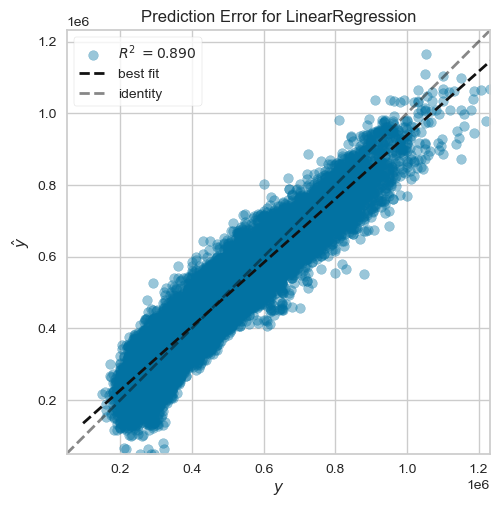

Linear Regression
R2 (train): 0.8911438107836038
R2 (test): 0.8904028807938098
RMSE: 47162.33379890041
-----------------------------------------------------

Ridge
R2 (train): 0.8911186381858723
R2 (test): 0.8903871642011166
RMSE: 47165.715295714814
-----------------------------------------------------

Lasso
R2 (train): 0.5761455842610013
R2 (test): 0.5751098890516184
RMSE: 92861.14408075622
-----------------------------------------------------



In [73]:
# Define the equation for model 1
equation = 'resale_price~' + joined_eq

plot_equation(housing_df, equation)

**Patsy Run for Model 2**:<br>

**The features for the 2nd prediction error analysis test are based on features correlation coefficient, feature engineering of region against flat types, popular ranking of primary schools & amenities that are known to affect housing prices.**

In [74]:
# List of categorical features to encode and numerical features to select
cat_name_m2 = ['full_flat_type', 'pri_sch_name','floor_height']
num_name_m2 = [
    'floor_area_sqm', 
    'lease_commence_date', 
    'tranc_year', 
    'tranc_month', 
    'max_floor_lvl', 
    'residential', 
    'commercial', 
    'market_hawker', 
    'multistorey_carpark', 
    'precinct_pavilion', 
    'total_dwelling_units', 
    'mall_nearest_distance', 
    'hawker_nearest_distance', 
    'mrt_nearest_distance', 
    'bus_stop_nearest_distance', 
    'pri_sch_nearest_distance', 
    'vacancy', 
    'sec_sch_nearest_dist', 
    'cutoff_point',
    'housing_region_ccr_1_room',
    'housing_region_ccr_2_room',
    'housing_region_ccr_3_room',
    'housing_region_ccr_4_room',
    'housing_region_ccr_5_room',
    'housing_region_ccr_executive',
    'housing_region_ccr_multi_generation',
    'housing_region_rcr_1_room',
    'housing_region_rcr_2_room',
    'housing_region_rcr_3_room',
    'housing_region_rcr_4_room',
    'housing_region_rcr_5_room',
    'housing_region_rcr_executive',
    'housing_region_rcr_multi_generation',
    'housing_region_ocr_1_room',
    'housing_region_ocr_2_room',
    'housing_region_ocr_3_room',
    'housing_region_ocr_4_room',
    'housing_region_ocr_5_room',
    'housing_region_ocr_executive',
    'housing_region_ocr_multi_generation',
    'pop_ranking_2cat'
]

In [75]:
# Create a string that contains the equation that '+' all feature names
all_columns = "+".join(cat_name_m2 + num_name_m2)
all_columns

'full_flat_type+pri_sch_name+floor_height+floor_area_sqm+lease_commence_date+tranc_year+tranc_month+max_floor_lvl+residential+commercial+market_hawker+multistorey_carpark+precinct_pavilion+total_dwelling_units+mall_nearest_distance+hawker_nearest_distance+mrt_nearest_distance+bus_stop_nearest_distance+pri_sch_nearest_distance+vacancy+sec_sch_nearest_dist+cutoff_point+housing_region_ccr_1_room+housing_region_ccr_2_room+housing_region_ccr_3_room+housing_region_ccr_4_room+housing_region_ccr_5_room+housing_region_ccr_executive+housing_region_ccr_multi_generation+housing_region_rcr_1_room+housing_region_rcr_2_room+housing_region_rcr_3_room+housing_region_rcr_4_room+housing_region_rcr_5_room+housing_region_rcr_executive+housing_region_rcr_multi_generation+housing_region_ocr_1_room+housing_region_ocr_2_room+housing_region_ocr_3_room+housing_region_ocr_4_room+housing_region_ocr_5_room+housing_region_ocr_executive+housing_region_ocr_multi_generation+pop_ranking_2cat'

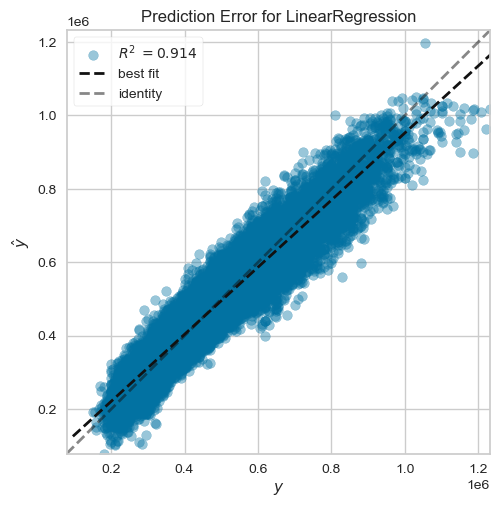

Linear Regression
R2 (train): 0.9147211168543598
R2 (test): 0.9137526758532102
RMSE: 41837.77050052418
-----------------------------------------------------

Ridge
R2 (train): 0.9146916189506403
R2 (test): 0.9137347928908378
RMSE: 41842.10770462869
-----------------------------------------------------

Lasso
R2 (train): 0.7071499094622089
R2 (test): 0.704646396761668
RMSE: 77422.44017241053
-----------------------------------------------------



In [76]:
# Define the equation
equation = 'resale_price~' + all_columns

plot_equation(housing_df, equation)

Although the Prediction Error Chart and metrics scores for this combination of features did exceptionally well, It performed badly when tested against the unseen data on Kaggle. This could be likely due to over fitting of data.

### One Hot Encoding

One Hot Encoding was used to convert categorical features to numeric for model input. A function was created to perform the One Hot Encoding and return the final dataframe for modeling (less the target: 'Resale_price'). This function will be used on both Train & test datasets.

In [77]:
# Create a function to perform the one hot encoding based on the selected categorical features from training data
def get_one_hot_encoded (data, cat_list, num_list):
    
    # Initialise One Hot Encoder & Column Transformer
    onehotencoder = OneHotEncoder(handle_unknown='ignore')
    transformer = ColumnTransformer([("enc",
                                       onehotencoder,
                                       cat_list)],
                                       remainder = "passthrough")
    
    # Fit the categorical feature names to transform on the housing dataset
    enc_data = transformer.fit(housing_df[cat_list])
    
    # Fill the train values
    enc_df = pd.DataFrame(transformer.transform(data[cat_list]).toarray())

    # Get the column Names
    enc_df.columns = transformer.get_feature_names_out(cat_list)

    # merge the encoded values with the numerical features
    merged_df = data[num_list].join(enc_df)
    
    return merged_df

## Modeling

**The following are a few functions created to perform train & test data splitting, models fitting & evaluation via R2 & RMSE metrics & GridSearchCV Hyperparameters tuning.**

In [78]:
# Create a function that takes in the X & y value and perform the data splitting and model evaluation
def get_model_score (X, y):
    # Split the data into train & test by 70 / 30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # apply scaling to X-variables to bring values to a similar scale for better model performance
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)

    # Instantiate the 3 models (Linear Regression, Ridge & lasso)
    lr = LinearRegression()
    ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))
    lasso = LassoCV(n_alphas=200)
    
    # Display the R2 score, RMSE & cross_val_score
    get_metrics_score('Linear Regression', lr, X_train, X_test, y_train, y_test)
    # Both Ridge & Lasso are scaled
    get_metrics_score('RidgeCV (With Scaling)', ridge, X_train_sc, X_test_sc, y_train, y_test)
    get_metrics_score('LassoCV (With Scaling)', lasso, X_train_sc, X_test_sc, y_train, y_test)
    
    return lr.fit(X_train, y_train).coef_
    
    
# Create a function that returns the score of a model's performance
def get_metrics_score (model_name:str, model, X_train, X_test, y_train, y_test):
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make prediction with the model
    y_pred = model.predict(X_test)
    
    print(model_name)
    print(f'R2 (train): {model.score(X_train, y_train)}')
    print(f'R2 (test): {model.score(X_test, y_test)}')
    print(f'Mean Cross Val Score (k=5): {cross_val_score(model, X_train, y_train, cv=5).mean()}')
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
    print(f'Mean Cross Val RMSE (k=5): {-cross_val_score(model, X_train, y_train, cv=5, scoring = "neg_root_mean_squared_error").mean()}')
    print('-----------------------------------------------------\n')
    
    

In [79]:
# Create a function that splits the data and run GridSearchCV on selected models for hyperparameters tuning
def get_gridsearch_params(X, y, model, params, folds):
    # Split the data into train & test by 70 / 30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # apply scaling to X-variables to bring values to a similar scale for better model performance
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    
    # Instantiate the GridSearchCV model
    gridsearchcv_model = GridSearchCV(estimator=model,
                                      param_grid=params,
                                      scoring='neg_root_mean_squared_error',
                                      cv=folds,
                                      verbose=2
    )
    
    # Fit the model
    gridsearchcv_model.fit(X_train_sc, y_train)
    return gridsearchcv_model.best_params_ # Return the best hyperparameters for the selected model

In [80]:
# Create a function that print out the scores for Ridge & Lasso model evaluation post tuning
def single_model_score(X, y, model):
    # Split the data into train & test by 70 / 30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # apply scaling to X-variables to bring values to a similar scale for better model performance
    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)

    # Fit the model
    model.fit(X_train_sc, y_train)
    
    # Make prediction with the model
    y_pred = model.predict(X_test_sc)
    
    print(f'R2 (train): {model.score(X_train_sc, y_train)}')
    print(f'R2 (test): {model.score(X_test_sc, y_test)}')
    print(f'Mean Cross Val Score (k=5): {cross_val_score(model, X_train_sc, y_train, cv=5).mean()}')
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')
    print(f'Mean Cross Val RMSE (k=5): {-cross_val_score(model, X_train_sc, y_train, cv=5, scoring = "neg_root_mean_squared_error").mean()}')
    print('-----------------------------------------------------\n')



## Baseline Model - set a benchmark on the model performance with all numeric features. Baseline model runs with all numeric features less id & price_per_sqft to predict resale_price.

In [81]:
# Drop unwanted columns
baseline_df = housing_df.drop(['price_per_sqft', 'id'], axis=1)
baseline_df

tranc_yearmonth             town         flat_type block  \
0              2016-05  kallang/whampoa            4_room    3b   
1              2012-07           bishan            5_room   153   
2              2013-07      bukit_batok         executive  289b   
3              2012-04           bishan            4_room   232   
4              2017-12           yishun            4_room   876   
...                ...              ...               ...   ...   
150629         2020-09        woodlands         executive   849   
150630         2017-06      jurong_west            5_room  648d   
150631         2020-12            bedok         executive   639   
150632         2016-05       queenstown            3_room    32   
150633         2018-06           yishun  multi-generation   666   

               street_name storey_range  floor_area_sqm        flat_model  \
0         upp_boon_keng_rd     10_to_12            90.0           model_a   
1             bishan_st_13     07_to_09           130.0          improved   
2           bt_batok_st_25     13_to_15           144.0         apartment   
3             bishan_st_22     01_to_05           103.0           model_a   
4             yishun_st_81     01_to_03            83.0        simplified   
...                    ...          ...             ...               ...   
150629     woodlands_st_82     04_to_06           161.0         apartment   
150630   jurong_west_st_61     04_to_06           110.0          improved   
150631  bedok_reservoir_rd     10_to_12           144.0         apartment   
150632          holland_cl     07_to_09            59.0          improved   
150633        yishun_ave_4     07_to_09           164.0  multi_generation   

        lease_commence_date  resale_price  tranc_year  tranc_month  \
0                      2006      680000.0        2016            5   
1                      1987      665000.0        2012            7   
2                      1997      838000.0        2013            7   
3                      1992      550000.0        2012            4   
4                      1987      298000.0        2017           12   
...                     ...           ...         ...          ...   
150629                 1995      625000.0        2020            9   
150630                 2001      455000.0        2017            6   
150631                 1993      733000.0        2020           12   
150632                 1974      338000.0        2016            5   
150633                 1987      765000.0        2018            6   

        mid_storey  lower  upper  mid                     full_flat_type  \
0               11     10     12   11                     4_room_model_a   
1                8      7      9    8                    5_room_improved   
2               14     13     15   14                executive_apartment   
3                3      1      5    3                     4_room_model_a   
4                2      1      3    2                  4_room_simplified   
...            ...    ...    ...  ...                                ...   
150629           5      4      6    5                executive_apartment   
150630           5      4      6    5                    5_room_improved   
150631          11     10     12   11                executive_apartment   
150632           8      7      9    8                    3_room_improved   
150633           8      7      9    8  multi-generation_multi_generation   

                        address  floor_area_sqft  hdb_age  max_floor_lvl  \
0          3b,_upp_boon_keng_rd          968.760       15             25   
1             153,_bishan_st_13         1399.320       34              9   
2          289b,_bt_batok_st_25         1550.016       24             16   
3             232,_bishan_st_22         1108.692       29             11   
4             876,_yishun_st_81          893.412       34              4   
...                         ...              ...      ...          

In [82]:
# Exclude all object type and set all numeric features as the X
X = baseline_df.select_dtypes(exclude='object').drop('resale_price', axis=1)
y = baseline_df['resale_price']

baseline_coef = get_model_score(X, y)

Linear Regression
R2 (train): 0.864525777946864
R2 (test): 0.862349107150159
Mean Cross Val Score (k=5): 0.8642889044947696
RMSE: 52854.89747460333
Mean Cross Val RMSE (k=5): 52920.424690676664
-----------------------------------------------------

RidgeCV (With Scaling)
R2 (train): 0.8645252807427294
R2 (test): 0.8623511854397269
Mean Cross Val Score (k=5): 0.8642885433852815
RMSE: 52854.49846449016
Mean Cross Val RMSE (k=5): 52920.490535725214
-----------------------------------------------------

LassoCV (With Scaling)
R2 (train): 0.8637879261968777
R2 (test): 0.8616157406593346
Mean Cross Val Score (k=5): 0.8635806647307647
RMSE: 52995.50869257812
Mean Cross Val RMSE (k=5): 53058.25796361279
-----------------------------------------------------



## Model 1 - the feature selection are based on domain knowledge of the elements that are known to affect housing prices. We will be using 4 categorical features as shown below that requires one hot encoding.

**Target: resale_price**

1. `town` (cat)
2. `storey_range` (cat)
3. `full_flat_type` (cat)
4. `pri_sch_name` (cat)
5. floor_area_sqm
6. lease_commence_date
7. mrt_nearest_distance
8. hawker_nearest_distance
9. mall_nearest_distance
10. pri_sch_nearest_distance

In [83]:
# List of categorical features to encode and numerical features to select
cat_name_m1 = ['town', 'storey_range','full_flat_type', 'pri_sch_name']
num_name_m1 = [
    'floor_area_sqm',
    'lease_commence_date',
    'mrt_nearest_distance',
    'hawker_nearest_distance',
    'mall_nearest_distance',
    'pri_sch_nearest_distance'
]

display(cat_name_m1)
display(num_name_m1)

['town', 'storey_range', 'full_flat_type', 'pri_sch_name']

['floor_area_sqm',
 'lease_commence_date',
 'mrt_nearest_distance',
 'hawker_nearest_distance',
 'mall_nearest_distance',
 'pri_sch_nearest_distance']

In [84]:
# Define the X & one Hot Encode those Categorical features for Model 1
model1_df = get_one_hot_encoded(housing_df, cat_name_m1, num_name_m1)
model1_df.head()

floor_area_sqm  lease_commence_date  mrt_nearest_distance  \
0            90.0                 2006            330.083069   
1           130.0                 1987            903.659703   
2           144.0                 1997           1334.251197   
3           103.0                 1992            907.453484   
4            83.0                 1987            412.343032   

   hawker_nearest_distance  mall_nearest_distance  pri_sch_nearest_distance  \
0               154.753357            1094.090418               1138.633422   
1               640.151925             866.941448                415.607357   
2              1762.082341            1459.579948                498.849039   
3               726.215262             950.175199                389.515528   
4              1540.151439             729.771895                401.200584   

   enc__town_ang_mo_kio  enc__town_bedok  enc__town_bishan  \
0                   0.0              0.0               0.0   
1                   0.0              0.0               1.0   
2                   0.0              0.0               0.0   
3                   0.0              0.0               1.0   
4                   0.0              0.0               0.0   

   enc__town_bukit_batok  enc__town_bukit_merah  enc__town_bukit_panjang  \
0                    0.0                    0.0                      0.0   
1                    0.0                    0.0                      0.0   
2                    1.0                    0.0                      0.0   
3                    0.0                    0.0                      0.0   
4                    0.0                    0.0                      0.0   

   enc__town_bukit_timah  enc__town_central_area  enc__town_choa_chu_kang  \
0                    0.0                     0.0                      0.0   
1                    0.0                     0.0                      0.0   
2                    0.0                     0.0                      0.0   
3                    0.0                     0.0                      0.0   
4                    0.0                     0.0                      0.0   

   enc__town_clementi  enc__town_geylang  enc__town_hougang  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0   
2                 0.0                0.0                0.0   
3                 0.0                0.0                0.0   
4                 0.0                0.0                0.0   

   enc__town_jurong_east  enc__town_jurong_west  enc__town_kallang/whampoa  \
0                    0.0                    0.0                        1.0   
1                    0.0                    0.0                        0.0   
2                    0.0                    0.0                        0.0   
3                    0.0                    0.0                        0.0   
4                    0.0                    0.0                        0.0   

   enc__town_marine_parade  enc__town_pasir_ris  enc__town_punggol  \
0                      0.0                  0.0                0.0   
1                      0.0                  0.0                0.0   
2                      0.0                  0.0                0.0   
3                      0.0                  0.0                0.0   
4                      0.0                  0.0                0.0   

   enc__town_queenstown  enc__town_sembawang  enc__town_sengkang  \
0                   0.0                  0.0                 0.0   
1                   0.0                  0.0                 0.0   
2                   0.0                  0.0                 0.0   
3                   0.0                  0.0                 0.0   
4                   0.0                  0.0                 0.0   

   enc__town_serangoon  enc__town_tampines  enc__town_toa_payoh  \
0                  0.0                 0.0                  0.0   
1                  0.0                

In [85]:
# Select the X & y features
X = model1_df
y = housing_df['resale_price']

# Run the function to get the models score
m1_coef = get_model_score(X, y)

Linear Regression
R2 (train): 0.8911438118465859
R2 (test): 0.8904030207739998
Mean Cross Val Score (k=5): 0.8903784251007234
RMSE: 47162.30368043287
Mean Cross Val RMSE (k=5): 47564.089240613896
-----------------------------------------------------

RidgeCV (With Scaling)
R2 (train): 0.8911436244562831
R2 (test): 0.8904043400403331
Mean Cross Val Score (k=5): 0.8903826951249998
RMSE: 47162.01982303495
Mean Cross Val RMSE (k=5): 47563.17004431846
-----------------------------------------------------

LassoCV (With Scaling)
R2 (train): 0.8904883083751722
R2 (test): 0.8897661056923573
Mean Cross Val Score (k=5): 0.889764014743001
RMSE: 47299.14535060859
Mean Cross Val RMSE (k=5): 47697.14884179061
-----------------------------------------------------



### Hyperparameters Tuning for Model 1:<br>
<br>
Model 1 has the best RMSE score among all the other models when uploaded onto Kaggle. Lets see if we can perform some hyperparameters tuning for Ridge & Lasso model to further improve the model performance.

In [86]:
# Define the GridSearch parameters
params = {
    'alpha':[0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 
             1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 200, 500, 1000 ]
}

# initialise the model
ridge = Ridge()

# Define the cross validation folds
folds = 5

In [87]:
# Run the function to perform GridSearchCV based on the parameters defined
display(get_gridsearch_params(X, y, ridge, params, folds))

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] END .......................................alpha=0.0001; total time=   0.5s
[CV] END .......................................alpha=0.0001; total time=   0.6s
[CV] END .......................................alpha=0.0001; total time=   0.6s
[CV] END .......................................alpha=0.0001; total time=   0.6s
[CV] END .......................................alpha=0.0001; total time=   0.6s
[CV] END ........................................alpha=0.001; total time=   0.5s
[CV] END ........................................alpha=0.001; total time=   0.5s
[CV] END ........................................alpha=0.001; total time=   0.5s
[CV] END ........................................alpha=0.001; total time=   0.5s
[CV] END ........................................alpha=0.001; total time=   0.6s
[CV] END .........................................alpha=0.01; total time=   0.7s
[CV] END ......................................

[CV] END ..........................................alpha=8.0; total time=   0.5s
[CV] END ..........................................alpha=8.0; total time=   0.5s
[CV] END ..........................................alpha=8.0; total time=   0.5s
[CV] END ..........................................alpha=8.0; total time=   0.5s
[CV] END ..........................................alpha=9.0; total time=   0.5s
[CV] END ..........................................alpha=9.0; total time=   0.5s
[CV] END ..........................................alpha=9.0; total time=   0.5s
[CV] END ..........................................alpha=9.0; total time=   0.5s
[CV] END ..........................................alpha=9.0; total time=   0.5s
[CV] END .........................................alpha=10.0; total time=   0.5s
[CV] END .........................................alpha=10.0; total time=   0.5s
[CV] END .........................................alpha=10.0; total time=   0.5s
[CV] END ...................

{'alpha': 1.0}

In [88]:
# Instantiate a ridge model with alpha = 1.0
ridge = Ridge(alpha=1.0)

# Get the model score for the tuned model
single_model_score(X, y, ridge)

R2 (train): 0.8911437859330669
R2 (test): 0.8904035498226909
Mean Cross Val Score (k=5): 0.8903828338077349
RMSE: 47162.18984889611
Mean Cross Val RMSE (k=5): 47563.140524613635
-----------------------------------------------------



Alpha 1.0 is actually the default alpha value for Ridge model. Hence the score is the same as Model 1. Lets do a Grid Search for Lasso.

In [89]:
# initialise the function. In order to prevent convergence warning, max iter & tol are preset prior GridSearch
lasso = Lasso(max_iter=5000, tol=0.1)

display(get_gridsearch_params(X, y, lasso, params, folds))

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] END .......................................alpha=0.0001; total time=   0.8s
[CV] END .......................................alpha=0.0001; total time=   0.7s
[CV] END .......................................alpha=0.0001; total time=   0.7s
[CV] END .......................................alpha=0.0001; total time=   0.7s
[CV] END .......................................alpha=0.0001; total time=   0.7s
[CV] END ........................................alpha=0.001; total time=   0.7s
[CV] END ........................................alpha=0.001; total time=   0.7s
[CV] END ........................................alpha=0.001; total time=   0.7s
[CV] END ........................................alpha=0.001; total time=   0.7s
[CV] END ........................................alpha=0.001; total time=   0.7s
[CV] END .........................................alpha=0.01; total time=   0.7s
[CV] END ......................................

[CV] END ..........................................alpha=8.0; total time=   0.7s
[CV] END ..........................................alpha=8.0; total time=   0.7s
[CV] END ..........................................alpha=8.0; total time=   0.7s
[CV] END ..........................................alpha=8.0; total time=   0.7s
[CV] END ..........................................alpha=9.0; total time=   0.7s
[CV] END ..........................................alpha=9.0; total time=   0.7s
[CV] END ..........................................alpha=9.0; total time=   0.6s
[CV] END ..........................................alpha=9.0; total time=   0.7s
[CV] END ..........................................alpha=9.0; total time=   0.7s
[CV] END .........................................alpha=10.0; total time=   0.7s
[CV] END .........................................alpha=10.0; total time=   0.7s
[CV] END .........................................alpha=10.0; total time=   0.7s
[CV] END ...................

{'alpha': 50}

In [90]:
# Initiate a lasso model with alpha = 50
lasso = Lasso(alpha=50,
              max_iter=5000, 
              tol=0.1
)

# Get the model score for the tuned model
single_model_score(X, y, lasso)

R2 (train): 0.8787921568900542
R2 (test): 0.8782500971609277
Mean Cross Val Score (k=5): 0.8780224242183398
RMSE: 49708.4281128504
Mean Cross Val RMSE (k=5): 50172.887735045704
-----------------------------------------------------



Lasso model didn't seem to be an improvement to the linear model. Setting a lower max_iter and tol will result in convergence warning.

## Model 2 - the features selection are based on features correlation coefficient, feature engineering of region against flat types, popular ranking of primary schools & amenities that are known to affect housing prices.

Target: resale_price

1.   floor_area_sqm
2.   lease_commence_date  
3.   tranc_year 
4.   tranc_month 
5.   `full_flat_type` (Cat)
6.   max_floor_lvl  
7.   residential 
8.   commercial
9.   market_hawker  
10.  multistorey_carpark 
11.  precinct_pavilion 
12.  total_dwelling_units 
13.  mall_nearest_distance
14.  hawker_nearest_distance
15.  mrt_nearest_distance
16.  bus_stop_nearest_distance
17.  pri_sch_nearest_distance
18.  `pri_sch_name` (Cat)
19.  vacancy
20.  sec_sch_nearest_dist
21.  cutoff_point 
22.  `floor_height` (Cat) 
23.  housing_region_ccr_1_room
24.  housing_region_ccr_2_room
25.  housing_region_ccr_3_room
26.  housing_region_ccr_4_room  
27.  housing_region_ccr_5_room
28.  housing_region_ccr_executive  
29.  housing_region_ccr_multi_generation 
30.  housing_region_rcr_1_room    
31.  housing_region_rcr_2_room   
32.  housing_region_rcr_3_room 
33.  housing_region_rcr_4_room
34.  housing_region_rcr_5_room 
35.  housing_region_rcr_executive   
36.  housing_region_rcr_multi_generation 
37.  housing_region_ocr_1_room
38.  housing_region_ocr_2_room  
39.  housing_region_ocr_3_room 
40.  housing_region_ocr_4_room 
41.  housing_region_ocr_5_room
42.  housing_region_ocr_executive  
43.  housing_region_ocr_multi_generation  
44.  pop_ranking_2cat

In [91]:
# List of categorical features to encode and numerical features to select
cat_name_m2 = ['full_flat_type', 'pri_sch_name','floor_height']
num_name_m2 = [
    'floor_area_sqm', 
    'lease_commence_date', 
    'tranc_year', 
    'tranc_month', 
    'max_floor_lvl', 
    'residential', 
    'commercial', 
    'market_hawker', 
    'multistorey_carpark', 
    'precinct_pavilion', 
    'total_dwelling_units', 
    'mall_nearest_distance', 
    'hawker_nearest_distance', 
    'mrt_nearest_distance', 
    'bus_stop_nearest_distance', 
    'pri_sch_nearest_distance', 
    'vacancy', 
    'sec_sch_nearest_dist', 
    'cutoff_point',
    'housing_region_ccr_1_room',
    'housing_region_ccr_2_room',
    'housing_region_ccr_3_room',
    'housing_region_ccr_4_room',
    'housing_region_ccr_5_room',
    'housing_region_ccr_executive',
    'housing_region_ccr_multi_generation',
    'housing_region_rcr_1_room',
    'housing_region_rcr_2_room',
    'housing_region_rcr_3_room',
    'housing_region_rcr_4_room',
    'housing_region_rcr_5_room',
    'housing_region_rcr_executive',
    'housing_region_rcr_multi_generation',
    'housing_region_ocr_1_room',
    'housing_region_ocr_2_room',
    'housing_region_ocr_3_room',
    'housing_region_ocr_4_room',
    'housing_region_ocr_5_room',
    'housing_region_ocr_executive',
    'housing_region_ocr_multi_generation',
    'pop_ranking_2cat'
]

display(cat_name_m2)
display(num_name_m2)

['full_flat_type', 'pri_sch_name', 'floor_height']

['floor_area_sqm',
 'lease_commence_date',
 'tranc_year',
 'tranc_month',
 'max_floor_lvl',
 'residential',
 'commercial',
 'market_hawker',
 'multistorey_carpark',
 'precinct_pavilion',
 'total_dwelling_units',
 'mall_nearest_distance',
 'hawker_nearest_distance',
 'mrt_nearest_distance',
 'bus_stop_nearest_distance',
 'pri_sch_nearest_distance',
 'vacancy',
 'sec_sch_nearest_dist',
 'cutoff_point',
 'housing_region_ccr_1_room',
 'housing_region_ccr_2_room',
 'housing_region_ccr_3_room',
 'housing_region_ccr_4_room',
 'housing_region_ccr_5_room',
 'housing_region_ccr_executive',
 'housing_region_ccr_multi_generation',
 'housing_region_rcr_1_room',
 'housing_region_rcr_2_room',
 'housing_region_rcr_3_room',
 'housing_region_rcr_4_room',
 'housing_region_rcr_5_room',
 'housing_region_rcr_executive',
 'housing_region_rcr_multi_generation',
 'housing_region_ocr_1_room',
 'housing_region_ocr_2_room',
 'housing_region_ocr_3_room',
 'housing_region_ocr_4_room',
 'housing_region_ocr_5_room',


In [92]:
# One Hot Encode the categorical features for mf_housing_df
model2_df = get_one_hot_encoded(housing_df, cat_name_m2, num_name_m2)
model2_df.head()

floor_area_sqm  lease_commence_date  tranc_year  tranc_month  \
0            90.0                 2006        2016            5   
1           130.0                 1987        2012            7   
2           144.0                 1997        2013            7   
3           103.0                 1992        2012            4   
4            83.0                 1987        2017           12   

   max_floor_lvl  residential  commercial  market_hawker  multistorey_carpark  \
0             25            1           0              0                    0   
1              9            1           0              0                    0   
2             16            1           0              0                    0   
3             11            1           1              0                    0   
4              4            1           0              0                    0   

   precinct_pavilion  total_dwelling_units  mall_nearest_distance  \
0                  0                   142            1094.090418   
1                  0                   112             866.941448   
2                  0                    90            1459.579948   
3                  0                    75             950.175199   
4                  0                    48             729.771895   

   hawker_nearest_distance  mrt_nearest_distance  bus_stop_nearest_distance  \
0               154.753357            330.083069                  29.427395   
1               640.151925            903.659703                  58.207761   
2              1762.082341           1334.251197                 214.747860   
3               726.215262            907.453484                  43.396521   
4              1540.151439            412.343032                 129.422752   

   pri_sch_nearest_distance  vacancy  sec_sch_nearest_dist  cutoff_point  \
0               1138.633422       78           1138.633422           224   
1                415.607357       45            447.894399           232   
2                498.849039       39            180.074558           188   
3                389.515528       20            389.515528           253   
4                401.200584       74            312.025435           208   

   housing_region_ccr_1_room  housing_region_ccr_2_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   housing_region_ccr_3_room  housing_region_ccr_4_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   housing_region_ccr_5_room  housing_region_ccr_executive  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   housing_region_ccr_multi_generation  housing_region_rcr_1_room  \
0                                    0                          0   
1                                    0                          0   
2                                    0                          0   
3                                    0                          0   
4                                    0                          0   

   housing_region_rcr_2_room  housing_region_rcr_3_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0    

In [93]:
# Select the X & y features
X = model2_df
y = housing_df['resale_price']

# Run the function to get the models score
m2_coef = get_model_score(X, y)

Linear Regression
R2 (train): 0.91472110588784
R2 (test): 0.9137526205470954
Mean Cross Val Score (k=5): -65076.32155545477
RMSE: 41837.783914761625
Mean Cross Val RMSE (k=5): 16317990.935625348
-----------------------------------------------------

RidgeCV (With Scaling)
R2 (train): 0.9147210555743941
R2 (test): 0.9137528310828595
Mean Cross Val Score (k=5): 0.9141069532965611
RMSE: 41837.732850281536
Mean Cross Val RMSE (k=5): 42102.88522534033
-----------------------------------------------------

LassoCV (With Scaling)
R2 (train): 0.9141639854045364
R2 (test): 0.9132210836252057
Mean Cross Val Score (k=5): 0.913567605418414
RMSE: 41966.507644467034
Mean Cross Val RMSE (k=5): 42234.486586530424
-----------------------------------------------------



### Model 3 - Features for model 3 were selected based on the features from model 1 and feature importance from previous models. Unfortunately it did not perform as good as Model 1.

In [94]:
# List of categorical features to encode and numerical features to select
cat_name_m3 = ['town','full_flat_type', 'pri_sch_name','storey_range']
num_name_m3 = [
    'floor_area_sqm', 
    'lease_commence_date',
    'max_floor_lvl',
    'exec_sold', 
    'mall_nearest_distance', 
    'hawker_nearest_distance', 
    'mrt_nearest_distance', 
    'bus_stop_nearest_distance', 
    'pri_sch_nearest_distance',
    'housing_region_OCR'
]
display(cat_name_m3)
display(num_name_m3)

['town', 'full_flat_type', 'pri_sch_name', 'storey_range']

['floor_area_sqm',
 'lease_commence_date',
 'max_floor_lvl',
 'exec_sold',
 'mall_nearest_distance',
 'hawker_nearest_distance',
 'mrt_nearest_distance',
 'bus_stop_nearest_distance',
 'pri_sch_nearest_distance',
 'housing_region_OCR']

In [95]:
# One Hot Encode the categorical features for mf_housing_df
model3_df = get_one_hot_encoded(housing_df, cat_name_m3, num_name_m3)
model3_df.head()

floor_area_sqm  lease_commence_date  max_floor_lvl  exec_sold  \
0            90.0                 2006             25          0   
1           130.0                 1987              9          0   
2           144.0                 1997             16         60   
3           103.0                 1992             11          0   
4            83.0                 1987              4          0   

   mall_nearest_distance  hawker_nearest_distance  mrt_nearest_distance  \
0            1094.090418               154.753357            330.083069   
1             866.941448               640.151925            903.659703   
2            1459.579948              1762.082341           1334.251197   
3             950.175199               726.215262            907.453484   
4             729.771895              1540.151439            412.343032   

   bus_stop_nearest_distance  pri_sch_nearest_distance  housing_region_OCR  \
0                  29.427395               1138.633422                   0   
1                  58.207761                415.607357                   0   
2                 214.747860                498.849039                   1   
3                  43.396521                389.515528                   0   
4                 129.422752                401.200584                   1   

   enc__town_ang_mo_kio  enc__town_bedok  enc__town_bishan  \
0                   0.0              0.0               0.0   
1                   0.0              0.0               1.0   
2                   0.0              0.0               0.0   
3                   0.0              0.0               1.0   
4                   0.0              0.0               0.0   

   enc__town_bukit_batok  enc__town_bukit_merah  enc__town_bukit_panjang  \
0                    0.0                    0.0                      0.0   
1                    0.0                    0.0                      0.0   
2                    1.0                    0.0                      0.0   
3                    0.0                    0.0                      0.0   
4                    0.0                    0.0                      0.0   

   enc__town_bukit_timah  enc__town_central_area  enc__town_choa_chu_kang  \
0                    0.0                     0.0                      0.0   
1                    0.0                     0.0                      0.0   
2                    0.0                     0.0                      0.0   
3                    0.0                     0.0                      0.0   
4                    0.0                     0.0                      0.0   

   enc__town_clementi  enc__town_geylang  enc__town_hougang  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0   
2                 0.0                0.0                0.0   
3                 0.0                0.0                0.0   
4                 0.0                0.0                0.0   

   enc__town_jurong_east  enc__town_jurong_west  enc__town_kallang/whampoa  \
0                    0.0                    0.0                        1.0   
1                    0.0                    0.0                        0.0   
2                    0.0                    0.0                        0.0   
3                    0.0                    0.0                        0.0   
4                    0.0                    0.0                        0.0   

   enc__town_marine_parade  enc__town_pasir_ris  enc__town_punggol  \
0                      0.0                  0.0                0.0   
1                      0.0                  0.0                0.0   
2                      0.0                  0.0                0.0   
3                      0.0                  0.0                0.0   
4                      0.0                  0.0                0.0   

   enc__town_queenstown  enc__town_sembawang  enc__town_sengkang  \
0                   0.0                  0.0

In [96]:
# Select the X & y features
X = model3_df
y = housing_df['resale_price']

# Run the function to get the models score
m3_coef = get_model_score(X, y)

Linear Regression
R2 (train): 0.8927460444706821
R2 (test): 0.8920518050046049
Mean Cross Val Score (k=5): 0.8919704943381801
RMSE: 46806.20289045079
Mean Cross Val RMSE (k=5): 47217.27042354515
-----------------------------------------------------

RidgeCV (With Scaling)
R2 (train): 0.8927459202171592
R2 (test): 0.8920528959305474
Mean Cross Val Score (k=5): 0.8919748904925564
RMSE: 46805.96637778835
Mean Cross Val RMSE (k=5): 47216.31674359936
-----------------------------------------------------

LassoCV (With Scaling)
R2 (train): 0.8920820794001926
R2 (test): 0.8914917508413369
Mean Cross Val Score (k=5): 0.8913596945119107
RMSE: 46927.46520518454
Mean Cross Val RMSE (k=5): 47350.38715208975
-----------------------------------------------------



The model seems to be a very slight 2 decimal-place improvement as compared to model 1 however, the model did not perform well on unseen data on Kaggle.

## Kaggle Submission

Import the test csv and prepare the prediction csv file for submission to kaggle.

In [99]:
test_df = pd.read_csv('../datasets/test.csv')
test_df.isna().sum()

C:\Users\LENOVO YOGA CORE I5\AppData\Local\Temp\ipykernel_5212\1028588701.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('../datasets/test.csv')


id                               0
Tranc_YearMonth                  0
town                             0
flat_type                        0
block                            0
street_name                      0
storey_range                     0
floor_area_sqm                   0
flat_model                       0
lease_commence_date              0
Tranc_Year                       0
Tranc_Month                      0
mid_storey                       0
lower                            0
upper                            0
mid                              0
full_flat_type                   0
address                          0
floor_area_sqft                  0
price_per_sqft                   0
hdb_age                          0
max_floor_lvl                    0
year_completed                   0
residential                      0
commercial                       0
market_hawker                    0
multistorey_carpark              0
precinct_pavilion                0
total_dwelling_units

In [100]:
test_df.shape

(16737, 77)

**Data Cleaning + Feature Engineering for test.csv**

In order to make prediction with the trained model, we have to repeat the data cleaning & feature engneering perform on training data to the test dataset.

In [101]:
# Assuming those null values for hawkers & malls nearest distance are zero.
test_df.fillna(0, inplace=True)

In [102]:
# Check if null values were replaced.
test_df.isna().sum().sum()

0

In [103]:
# Standardise the column names to lower case
test_df.rename(str.lower, axis=1, inplace=True)

In [104]:
# Loop through the object features and replace the spaces with '_' and change all to lower cases
for feature in test_df.select_dtypes(include='object'):
    test_df[feature] = test_df[feature].replace(to_replace=' ', value='_', regex=True).str.lower()

In [105]:
# Change all data type to string
test_df['postal']=housing_df['postal'].astype(str)

In [106]:
# Postal codes are 6 digits long. Check if there is any abnormal data
postal_issues=test_df[test_df['postal'].str.len() !=6]
postal_issues['postal']

Series([], Name: postal, dtype: object)

In [107]:
# Obtaining postal sector
test_df['postal_sector']=test_df['postal'].str[:2]

In [108]:
# Classifying by postal sector
CCR_postal_sector=['01', '02', '03', '04', '05', '06', '07', '08', '17', '22', '23', '24', '25', '26', '27', '28', '29', '30']
RCR_postal_sector=['14', '15', '16', '09', '10', '11', '12', '13', '18', '19', '20', '21', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '56', '57']
OCR_postal_sector=['46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '77', '78', '81', '82']

In [109]:
# Assigning housing region
test_df.loc[test_df['postal_sector'].isin(CCR_postal_sector), 'housing_region'] = 'CCR'
test_df.loc[test_df['postal_sector'].isin(RCR_postal_sector), 'housing_region'] = 'RCR'
test_df.loc[~test_df['postal_sector'].isin(CCR_postal_sector + RCR_postal_sector), 'housing_region'] = 'OCR'

In [110]:
# Get dummies for housing region
housing_region_dummy=pd.get_dummies(test_df['housing_region'], prefix='housing_region')

In [111]:
# Concat dummies for housing region into the main test_df
test_df=pd.concat([test_df, housing_region_dummy], axis=1)

In [112]:
test_df.head()

id tranc_yearmonth         town flat_type block          street_name  \
0  114982         2012-11       yishun    4_room   173         yishun_ave_7   
1   95653         2019-08  jurong_west    5_room  986c    jurong_west_st_93   
2   40303         2013-10   ang_mo_kio    3_room   534    ang_mo_kio_ave_10   
3  109506         2017-10    woodlands    4_room    29         marsiling_dr   
4  100149         2016-08  bukit_batok    4_room   170  bt_batok_west_ave_8   

  storey_range  floor_area_sqm         flat_model  lease_commence_date  \
0     07_to_09            84.0         simplified                 1987   
1     04_to_06           112.0  premium_apartment                 2008   
2     07_to_09            68.0     new_generation                 1980   
3     01_to_03            97.0     new_generation                 1979   
4     16_to_18           103.0            model_a                 1985   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2012           11           8      7      9    8   
1        2019            8           5      4      6    5   
2        2013           10           8      7      9    8   
3        2017           10           2      1      3    2   
4        2016            8          17     16     18   17   

             full_flat_type                   address  floor_area_sqft  \
0         4_room_simplified         173,_yishun_ave_7          904.176   
1  5_room_premium_apartment   986c,_jurong_west_st_93         1205.568   
2     3_room_new_generation    534,_ang_mo_kio_ave_10          731.952   
3     4_room_new_generation          29,_marsiling_dr         1044.108   
4            4_room_model_a  170,_bt_batok_west_ave_8         1108.692   

   price_per_sqft  hdb_age  max_floor_lvl  year_completed residential  \
0      399.258551       34             12            1986           y   
1      398.152572       13             14            2002           y   
2      479.386626       41             12            1979           y   
3      306.481705       42             14            1976           y   
4      360.784600       36             25            1985           y   

  commercial market_hawker multistorey_carpark precinct_pavilion  \
0          y             n                   n                 n   
1          n             n                   n                 n   
2          n             n                   n                 n   
3          n             n                   n                 n   
4          n             n                   n                 n   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   132           0           0           0          92   
1                    53           0           0           0          28   
2                   218           0           0         191          22   
3                   104           0           0           0         104   
4                   144           0           0           0          48   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          40          0              0                      0             0   
1          25          0              0                      0             0   
2           1          1              0                      0             0   
3           0          0              0                      0             0   
4          96          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.437066   
1             0             0                  0  570153  1.336957   
2             0             3                  0  651289  1.374058   
3             0             0                  0  570232  1.442748   
4             0             0                  0  760876  1.346556   

    longitude planning_area  mall_nearest_distance  mall_within_500m  \
0 

In [113]:
test_df_filtered = test_df.drop(['id', 'tranc_yearmonth', 'hdb_age', 'planning_area', 'address',
                                       'block','street_name','latitude','longitude','storey_range','lower','mid_storey',
                                       'upper', 'price_per_sqft', 'floor_area_sqft'], axis=1)
test_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   town                       16737 non-null  object 
 1   flat_type                  16737 non-null  object 
 2   floor_area_sqm             16737 non-null  float64
 3   flat_model                 16737 non-null  object 
 4   lease_commence_date        16737 non-null  int64  
 5   tranc_year                 16737 non-null  int64  
 6   tranc_month                16737 non-null  int64  
 7   mid                        16737 non-null  int64  
 8   full_flat_type             16737 non-null  object 
 9   max_floor_lvl              16737 non-null  int64  
 10  year_completed             16737 non-null  int64  
 11  residential                16737 non-null  object 
 12  commercial                 16737 non-null  object 
 13  market_hawker              16737 non-null  obj

**num_df**
- All numerical values from filtered dataframe (df_filtered)

**num_with_otherprop**
- Changing objects columns of 'OTHER PROPERTIES OF BLOCK' to integers:  Y/N  to 1/0 values.
- Then merge with num_df

In [114]:
# One copy of dataframe with NUMERICAL data only
num_df =  test_df_filtered.select_dtypes(exclude=['object'])
#display(num_df.info())

# One copy of dataframe with numerical data after converting "OTHER PROPERTIES OF BLOCK" object into integers
columns_to_replace = ['residential', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']
int_cols = test_df_filtered.loc[:, columns_to_replace].replace({'y': 1, 'n': 0})
num_with_otherprop = pd.concat([num_df,int_cols], axis=1)
print(num_with_otherprop.info())

# One copy of dataframe with Primary School Ranking (pop_ranking) added
# Merge the two DataFrames on the common column "pri_sch_name"
psch_name_df = test_df_filtered[['pri_sch_name']]
pri_ranking = psch_name_df.merge(psch_pop_df, on='pri_sch_name', how='left')
num_with_otherprop_and_prirank = pd.concat([num_df, pri_ranking['pop_ranking']], axis=1)
display(pri_ranking)
display(num_with_otherprop_and_prirank)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   floor_area_sqm             16737 non-null  float64
 1   lease_commence_date        16737 non-null  int64  
 2   tranc_year                 16737 non-null  int64  
 3   tranc_month                16737 non-null  int64  
 4   mid                        16737 non-null  int64  
 5   max_floor_lvl              16737 non-null  int64  
 6   year_completed             16737 non-null  int64  
 7   total_dwelling_units       16737 non-null  int64  
 8   1room_sold                 16737 non-null  int64  
 9   2room_sold                 16737 non-null  int64  
 10  3room_sold                 16737 non-null  int64  
 11  4room_sold                 16737 non-null  int64  
 12  5room_sold                 16737 non-null  int64  
 13  exec_sold                  16737 non-null  int

pri_sch_name  pop_ranking
0               ahmad_ibrahim_primary_school          132
1                 jurong_west_primary_school           94
2                   jing_shan_primary_school          120
3                   marsiling_primary_school          132
4          princess_elizabeth_primary_school           15
...                                      ...          ...
16732               mayflower_primary_school          132
16733            punggol_view_primary_school           68
16734                   unity_primary_school          132
16735  kuo_chuan_presbyterian_primary_school           24
16736                lakeside_primary_school           89

[16737 rows x 2 columns]

floor_area_sqm  lease_commence_date  tranc_year  tranc_month  mid  \
0                84.0                 1987        2012           11    8   
1               112.0                 2008        2019            8    5   
2                68.0                 1980        2013           10    8   
3                97.0                 1979        2017           10    2   
4               103.0                 1985        2016            8   17   
...               ...                  ...         ...          ...  ...   
16732            82.0                 1980        2016            6    5   
16733            92.0                 2012        2017            8   17   
16734           110.0                 2002        2018            3    5   
16735            84.0                 1988        2020           11    8   
16736           104.0                 1990        2012            6    8   

       max_floor_lvl  year_completed  total_dwelling_units  1room_sold  \
0                 12            1986                   132           0   
1                 14            2002                    53           0   
2                 12            1979                   218           0   
3                 14            1976                   104           0   
4                 25            1985                   144           0   
...              ...             ...                   ...         ...   
16732             11            1980                   258           0   
16733             16            2010                    80           0   
16734             16            2000                   120           0   
16735              9            1987                   104           0   
16736             13            1989                   100           0   

       2room_sold  3room_sold  4room_sold  5room_sold  exec_sold  \
0               0           0          92          40          0   
1               0           0          28          25          0   
2               0         191          22           1          1   
3               0           0         104           0          0   
4               0           0          48          96          0   
...           ...         ...         ...         ...        ...   
16732           0         196          60           2          0   
16733           0          14          64           2          0   
16734           0           0          30          90          0   
16735           0           0          64          40          0   
16736           0           0         100           0          0   

       multigen_sold  studio_apartment_sold  1room_rental  2room_rental  \
0                  0                      0             0             0   
1                  0                      0             0             0   
2                  0                      0             0             0   
3                  0                      0             0             0   
4                  0                      0             0             0   
...              ...                    ...           ...           ...   
16732              0                      0             0             0   
16733              0                      0             0             0   
16734              0                      0             0             0   
16735              0                      0             0             0   
16736              0                      0             0             0   

       3room_rental  other_room_rental  mall_nearest_distance  \
0                 0                  0             877.431572   
1                 0                  0             534.037705   
2                 3                  0             817.050453   
3                 0                  0            1272.737194   
4                 0                  0            1070.963675   
...             ...                ...                    ...   
16732             0             

In [115]:
# Updating the converted columns back into test_df
test_df[int_cols.columns] = int_cols

With storey_range & max_floor_level features, create low, mid & high floor level features.

In [116]:
test_df['storey_end'] = test_df['storey_range'].apply(lambda x: x.split('_')[-1]).astype(int)
test_df.head()

id tranc_yearmonth         town flat_type block          street_name  \
0  114982         2012-11       yishun    4_room   173         yishun_ave_7   
1   95653         2019-08  jurong_west    5_room  986c    jurong_west_st_93   
2   40303         2013-10   ang_mo_kio    3_room   534    ang_mo_kio_ave_10   
3  109506         2017-10    woodlands    4_room    29         marsiling_dr   
4  100149         2016-08  bukit_batok    4_room   170  bt_batok_west_ave_8   

  storey_range  floor_area_sqm         flat_model  lease_commence_date  \
0     07_to_09            84.0         simplified                 1987   
1     04_to_06           112.0  premium_apartment                 2008   
2     07_to_09            68.0     new_generation                 1980   
3     01_to_03            97.0     new_generation                 1979   
4     16_to_18           103.0            model_a                 1985   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2012           11           8      7      9    8   
1        2019            8           5      4      6    5   
2        2013           10           8      7      9    8   
3        2017           10           2      1      3    2   
4        2016            8          17     16     18   17   

             full_flat_type                   address  floor_area_sqft  \
0         4_room_simplified         173,_yishun_ave_7          904.176   
1  5_room_premium_apartment   986c,_jurong_west_st_93         1205.568   
2     3_room_new_generation    534,_ang_mo_kio_ave_10          731.952   
3     4_room_new_generation          29,_marsiling_dr         1044.108   
4            4_room_model_a  170,_bt_batok_west_ave_8         1108.692   

   price_per_sqft  hdb_age  max_floor_lvl  year_completed  residential  \
0      399.258551       34             12            1986            1   
1      398.152572       13             14            2002            1   
2      479.386626       41             12            1979            1   
3      306.481705       42             14            1976            1   
4      360.784600       36             25            1985            1   

   commercial  market_hawker  multistorey_carpark  precinct_pavilion  \
0           1              0                    0                  0   
1           0              0                    0                  0   
2           0              0                    0                  0   
3           0              0                    0                  0   
4           0              0                    0                  0   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   132           0           0           0          92   
1                    53           0           0           0          28   
2                   218           0           0         191          22   
3                   104           0           0           0         104   
4                   144           0           0           0          48   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          40          0              0                      0             0   
1          25          0              0                      0             0   
2           1          1              0                      0             0   
3           0          0              0                      0             0   
4          96          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.437066   
1             0             0                  0  570153  1.336957   
2             0             3                  0  651289  1.374058   
3             0             0                  0  570232  1.442748   
4             0             0                  0  760876  1.346556   

    longitude planning_area  mall_nearest_di

In [117]:
# Create a function that create low, mid & high category based on the storey_end
def categorize_floor(storey_end, max_floor_lvl):
    if max_floor_lvl <= 9:
        ratio = storey_end / max_floor_lvl
        if ratio <= 2/3:
            return 'low'
        else: 
            return 'mid'
            
    elif max_floor_lvl <= 18:
        ratio = storey_end / max_floor_lvl
        if ratio <= 1/3:
            return 'low'
        else: 
            return 'mid'    

    else:
        if storey_end <= 6:
            return 'low'
        elif storey_end <= 18:
            return 'mid'
        else:
            return 'high'       

test_df['floor_height'] = test_df.apply(lambda x: categorize_floor(x['storey_end'], x['max_floor_lvl']), axis=1)

In [118]:
test_df.head()

id tranc_yearmonth         town flat_type block          street_name  \
0  114982         2012-11       yishun    4_room   173         yishun_ave_7   
1   95653         2019-08  jurong_west    5_room  986c    jurong_west_st_93   
2   40303         2013-10   ang_mo_kio    3_room   534    ang_mo_kio_ave_10   
3  109506         2017-10    woodlands    4_room    29         marsiling_dr   
4  100149         2016-08  bukit_batok    4_room   170  bt_batok_west_ave_8   

  storey_range  floor_area_sqm         flat_model  lease_commence_date  \
0     07_to_09            84.0         simplified                 1987   
1     04_to_06           112.0  premium_apartment                 2008   
2     07_to_09            68.0     new_generation                 1980   
3     01_to_03            97.0     new_generation                 1979   
4     16_to_18           103.0            model_a                 1985   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2012           11           8      7      9    8   
1        2019            8           5      4      6    5   
2        2013           10           8      7      9    8   
3        2017           10           2      1      3    2   
4        2016            8          17     16     18   17   

             full_flat_type                   address  floor_area_sqft  \
0         4_room_simplified         173,_yishun_ave_7          904.176   
1  5_room_premium_apartment   986c,_jurong_west_st_93         1205.568   
2     3_room_new_generation    534,_ang_mo_kio_ave_10          731.952   
3     4_room_new_generation          29,_marsiling_dr         1044.108   
4            4_room_model_a  170,_bt_batok_west_ave_8         1108.692   

   price_per_sqft  hdb_age  max_floor_lvl  year_completed  residential  \
0      399.258551       34             12            1986            1   
1      398.152572       13             14            2002            1   
2      479.386626       41             12            1979            1   
3      306.481705       42             14            1976            1   
4      360.784600       36             25            1985            1   

   commercial  market_hawker  multistorey_carpark  precinct_pavilion  \
0           1              0                    0                  0   
1           0              0                    0                  0   
2           0              0                    0                  0   
3           0              0                    0                  0   
4           0              0                    0                  0   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   132           0           0           0          92   
1                    53           0           0           0          28   
2                   218           0           0         191          22   
3                   104           0           0           0         104   
4                   144           0           0           0          48   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          40          0              0                      0             0   
1          25          0              0                      0             0   
2           1          1              0                      0             0   
3           0          0              0                      0             0   
4          96          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.437066   
1             0             0                  0  570153  1.336957   
2             0             3                  0  651289  1.374058   
3             0             0                  0  570232  1.442748   
4             0             0                  0  760876  1.346556   

    longitude planning_area  mall_nearest_di

In [119]:
# Create a new housing_df called housing_df_location to investage correlations
test_df_location=test_df[['hdb_age', 'postal', 'postal_sector', 'housing_region', 'housing_region_CCR', 'housing_region_OCR', 'housing_region_RCR', 'flat_type']]

In [120]:
# Get dummies for flat_type
flat_type_dummy=pd.get_dummies(test_df_location['flat_type'])

In [121]:
# Concat dummies for flat type and test_df_location
test_df_location=pd.concat([test_df_location, flat_type_dummy], axis=1)

In [122]:
test_df_location

hdb_age  postal postal_sector housing_region  housing_region_CCR  \
0           34  382003            38            RCR                   0   
1           13  570153            57            RCR                   0   
2           41  651289            65            OCR                   0   
3           42  570232            57            RCR                   0   
4           36  760876            76            OCR                   0   
...        ...     ...           ...            ...                 ...   
16732       41  520873            52            OCR                   0   
16733        9  542335            54            OCR                   0   
16734       19  520272            52            OCR                   0   
16735       33  600270            60            OCR                   0   
16736       31  520817            52            OCR                   0   

       housing_region_OCR  housing_region_RCR flat_type  1_room  2_room  \
0                       0                   1    4_room       0       0   
1                       0                   1    5_room       0       0   
2                       1                   0    3_room       0       0   
3                       0                   1    4_room       0       0   
4                       1                   0    4_room       0       0   
...                   ...                 ...       ...     ...     ...   
16732                   1                   0    3_room       0       0   
16733                   1                   0    4_room       0       0   
16734                   1                   0    5_room       0       0   
16735                   1                   0    4_room       0       0   
16736                   1                   0    4_room       0       0   

       3_room  4_room  5_room  executive  multi-generation  
0           0       1       0          0                 0  
1           0       0       1          0                 0  
2           1       0       0          0                 0  
3           0       1       0          0                 0  
4           0       1       0          0                 0  
...       ...     ...     ...        ...               ...  
16732       1       0       0          0                 0  
16733       0       1       0          0                 0  
16734       0       0       1          0                 0  
16735       0       1       0          0                 0  
16736       0       1       0          0                 0  

[16737 rows x 15 columns]

In [123]:
# Create interaction term of housing_region * flat_type

for region_col in test_df_location[['housing_region_CCR', 'housing_region_RCR', 'housing_region_OCR']]:
    for flat_type_col in test_df_location[['1_room', '2_room', '3_room', '4_room', '5_room', 'executive', 'multi-generation']]:
        region_type=(region_col + '_' + flat_type_col).lower()
        test_df_location[region_type]=test_df_location[region_col]*test_df_location[flat_type_col]

In [124]:
test_df_location

hdb_age  postal postal_sector housing_region  housing_region_CCR  \
0           34  382003            38            RCR                   0   
1           13  570153            57            RCR                   0   
2           41  651289            65            OCR                   0   
3           42  570232            57            RCR                   0   
4           36  760876            76            OCR                   0   
...        ...     ...           ...            ...                 ...   
16732       41  520873            52            OCR                   0   
16733        9  542335            54            OCR                   0   
16734       19  520272            52            OCR                   0   
16735       33  600270            60            OCR                   0   
16736       31  520817            52            OCR                   0   

       housing_region_OCR  housing_region_RCR flat_type  1_room  2_room  \
0                       0                   1    4_room       0       0   
1                       0                   1    5_room       0       0   
2                       1                   0    3_room       0       0   
3                       0                   1    4_room       0       0   
4                       1                   0    4_room       0       0   
...                   ...                 ...       ...     ...     ...   
16732                   1                   0    3_room       0       0   
16733                   1                   0    4_room       0       0   
16734                   1                   0    5_room       0       0   
16735                   1                   0    4_room       0       0   
16736                   1                   0    4_room       0       0   

       3_room  4_room  5_room  executive  multi-generation  \
0           0       1       0          0                 0   
1           0       0       1          0                 0   
2           1       0       0          0                 0   
3           0       1       0          0                 0   
4           0       1       0          0                 0   
...       ...     ...     ...        ...               ...   
16732       1       0       0          0                 0   
16733       0       1       0          0                 0   
16734       0       0       1          0                 0   
16735       0       1       0          0                 0   
16736       0       1       0          0                 0   

       housing_region_ccr_1_room  housing_region_ccr_2_room  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   
...                          ...                        ...   
16732                          0                          0   
16733                          0                          0   
16734                          0                          0   
16735                          0                          0   
16736                          0                          0   

       housing_region_ccr_3_room  housing_region_ccr_4_room  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   
...                          ...                        ...   
16732                          0                          0   
16733                          0                          0   
16734                          0                          0   
16735                          0                          0   
16736     

In [125]:
test_df_location_corr=test_df_location.iloc[:, [7] + list(range(-21,0))]

In [126]:
# Add the newly created regional flat type into test_df
test_df = test_df.join(test_df_location_corr.drop('flat_type', axis=1))

In [127]:
name_dict = {}
# loop thru the columns names of test_df and correct the name by replacing spaces & '-' with '_'
for name in test_df.columns:
    name_dict[name] = name.replace('-','_')
# Correct the column names with the dict
test_df.rename(columns=name_dict,inplace=True)
test_df.head()

id tranc_yearmonth         town flat_type block          street_name  \
0  114982         2012-11       yishun    4_room   173         yishun_ave_7   
1   95653         2019-08  jurong_west    5_room  986c    jurong_west_st_93   
2   40303         2013-10   ang_mo_kio    3_room   534    ang_mo_kio_ave_10   
3  109506         2017-10    woodlands    4_room    29         marsiling_dr   
4  100149         2016-08  bukit_batok    4_room   170  bt_batok_west_ave_8   

  storey_range  floor_area_sqm         flat_model  lease_commence_date  \
0     07_to_09            84.0         simplified                 1987   
1     04_to_06           112.0  premium_apartment                 2008   
2     07_to_09            68.0     new_generation                 1980   
3     01_to_03            97.0     new_generation                 1979   
4     16_to_18           103.0            model_a                 1985   

   tranc_year  tranc_month  mid_storey  lower  upper  mid  \
0        2012           11           8      7      9    8   
1        2019            8           5      4      6    5   
2        2013           10           8      7      9    8   
3        2017           10           2      1      3    2   
4        2016            8          17     16     18   17   

             full_flat_type                   address  floor_area_sqft  \
0         4_room_simplified         173,_yishun_ave_7          904.176   
1  5_room_premium_apartment   986c,_jurong_west_st_93         1205.568   
2     3_room_new_generation    534,_ang_mo_kio_ave_10          731.952   
3     4_room_new_generation          29,_marsiling_dr         1044.108   
4            4_room_model_a  170,_bt_batok_west_ave_8         1108.692   

   price_per_sqft  hdb_age  max_floor_lvl  year_completed  residential  \
0      399.258551       34             12            1986            1   
1      398.152572       13             14            2002            1   
2      479.386626       41             12            1979            1   
3      306.481705       42             14            1976            1   
4      360.784600       36             25            1985            1   

   commercial  market_hawker  multistorey_carpark  precinct_pavilion  \
0           1              0                    0                  0   
1           0              0                    0                  0   
2           0              0                    0                  0   
3           0              0                    0                  0   
4           0              0                    0                  0   

   total_dwelling_units  1room_sold  2room_sold  3room_sold  4room_sold  \
0                   132           0           0           0          92   
1                    53           0           0           0          28   
2                   218           0           0         191          22   
3                   104           0           0           0         104   
4                   144           0           0           0          48   

   5room_sold  exec_sold  multigen_sold  studio_apartment_sold  1room_rental  \
0          40          0              0                      0             0   
1          25          0              0                      0             0   
2           1          1              0                      0             0   
3           0          0              0                      0             0   
4          96          0              0                      0             0   

   2room_rental  3room_rental  other_room_rental  postal  latitude  \
0             0             0                  0  382003  1.437066   
1             0             0                  0  570153  1.336957   
2             0             3                  0  651289  1.374058   
3             0             0                  0  570232  1.442748   
4             0             0                  0  760876  1.346556   

    longitude planning_area  mall_nearest_di

In [128]:
# Separating the school rankings into 2 categories. Rank 8 and above will be mapped to Rank 1 and the rest will be mapped to Rank 2.

pri_ranking['pop_ranking_2cat'] = pri_ranking['pop_ranking'].map(lambda x: 1 if x <= 8 else 2)
pri_ranking.head()

pri_sch_name  pop_ranking  pop_ranking_2cat
0       ahmad_ibrahim_primary_school          132                 2
1         jurong_west_primary_school           94                 2
2           jing_shan_primary_school          120                 2
3           marsiling_primary_school          132                 2
4  princess_elizabeth_primary_school           15                 2

In [129]:
# Adding the Popularity ranking into housing_df
test_df = test_df.join(pri_ranking['pop_ranking_2cat'])

In [130]:
test_df

id tranc_yearmonth           town flat_type block  \
0      114982         2012-11         yishun    4_room   173   
1       95653         2019-08    jurong_west    5_room  986c   
2       40303         2013-10     ang_mo_kio    3_room   534   
3      109506         2017-10      woodlands    4_room    29   
4      100149         2016-08    bukit_batok    4_room   170   
...       ...             ...            ...       ...   ...   
16732   23347         2016-06     ang_mo_kio    3_room   610   
16733   54003         2017-08        punggol    4_room  305a   
16734  128921         2018-03  choa_chu_kang    5_room  686d   
16735   69352         2020-11         bishan    4_room   167   
16736  146210         2012-06    jurong_west    4_room   152   

               street_name storey_range  floor_area_sqm         flat_model  \
0             yishun_ave_7     07_to_09            84.0         simplified   
1        jurong_west_st_93     04_to_06           112.0  premium_apartment   
2        ang_mo_kio_ave_10     07_to_09            68.0     new_generation   
3             marsiling_dr     01_to_03            97.0     new_generation   
4      bt_batok_west_ave_8     16_to_18           103.0            model_a   
...                    ...          ...             ...                ...   
16732     ang_mo_kio_ave_4     04_to_06            82.0     new_generation   
16733           punggol_rd     16_to_18            92.0  premium_apartment   
16734   choa_chu_kang_cres     04_to_06           110.0           improved   
16735         bishan_st_13     07_to_09            84.0         simplified   
16736           yung_ho_rd     07_to_09           104.0            model_a   

       lease_commence_date  tranc_year  tranc_month  mid_storey  lower  upper  \
0                     1987        2012           11           8      7      9   
1                     2008        2019            8           5      4      6   
2                     1980        2013           10           8      7      9   
3                     1979        2017           10           2      1      3   
4                     1985        2016            8          17     16     18   
...                    ...         ...          ...         ...    ...    ...   
16732                 1980        2016            6           5      4      6   
16733                 2012        2017            8          17     16     18   
16734                 2002        2018            3           5      4      6   
16735                 1988        2020           11           8      7      9   
16736                 1990        2012            6           8      7      9   

       mid            full_flat_type                   address  \
0        8         4_room_simplified         173,_yishun_ave_7   
1        5  5_room_premium_apartment   986c,_jurong_west_st_93   
2        8     3_room_new_generation    534,_ang_mo_kio_ave_10   
3        2     4_room_new_generation          29,_marsiling_dr   
4       17            4_room_model_a  170,_bt_batok_west_ave_8   
...    ...                       ...                       ...   
16732    5     3_room_new_generation     610,_ang_mo_kio_ave_4   
16733   17  4_room_premium_apartment          305a,_punggol_rd   
16734    5           5_room_improved  686d,_choa_chu_kang_cres   
16735    8         4_room_simplified         167,_bishan_st_13   
16736    8            4_room_model_a           152,_yung_ho_rd   

       floor_area_sqft  price_per_sqft  hdb_age  max_floor_lvl  \
0              904.176      399.258551       34             12   
1             1205.568      398.152572       13             14   
2              731.952      479.386626       41             12   
3             1044.108      306.481705       42             14   
4             1108.692      360.784600       36             25   
...                ...             ...      ...            ...   
16732          882.648      402.198838       41             11   
16733      

### Final Model 1

Model 1 is our best performing model using Linear Regression model. Fitting the whole of train.csv into the final model for test.csv prediction.

In [131]:
X = model1_df
y = housing_df['resale_price']

# call & fit the model
final_lr_model = LinearRegression()
final_lr_model.fit(X, y)

LinearRegression()

In [132]:
import pickle

#save the model to disk
filename = 'model1.csv'
pickle.dump(final_lr_model, open(filename, 'wb'))

In [133]:
# Get one hot encoded Test dataset.
model1_test_df = get_one_hot_encoded(test_df, cat_name_m1, num_name_m1)
model1_test_df.head()

floor_area_sqm  lease_commence_date  mrt_nearest_distance  \
0            84.0                 1987            686.660434   
1           112.0                 2008            169.478175   
2            68.0                 1980            694.220448   
3            97.0                 1979           1117.203587   
4           103.0                 1985            987.976010   

   hawker_nearest_distance  mall_nearest_distance  pri_sch_nearest_distance  \
0               687.576779             877.431572                426.467910   
1              2122.346226             534.037705                439.756851   
2               152.287621             817.050453                355.882207   
3               501.892158            1272.737194                929.744711   
4               437.593564            1070.963675                309.926934   

   enc__town_ang_mo_kio  enc__town_bedok  enc__town_bishan  \
0                   0.0              0.0               0.0   
1                   0.0              0.0               0.0   
2                   1.0              0.0               0.0   
3                   0.0              0.0               0.0   
4                   0.0              0.0               0.0   

   enc__town_bukit_batok  enc__town_bukit_merah  enc__town_bukit_panjang  \
0                    0.0                    0.0                      0.0   
1                    0.0                    0.0                      0.0   
2                    0.0                    0.0                      0.0   
3                    0.0                    0.0                      0.0   
4                    1.0                    0.0                      0.0   

   enc__town_bukit_timah  enc__town_central_area  enc__town_choa_chu_kang  \
0                    0.0                     0.0                      0.0   
1                    0.0                     0.0                      0.0   
2                    0.0                     0.0                      0.0   
3                    0.0                     0.0                      0.0   
4                    0.0                     0.0                      0.0   

   enc__town_clementi  enc__town_geylang  enc__town_hougang  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0   
2                 0.0                0.0                0.0   
3                 0.0                0.0                0.0   
4                 0.0                0.0                0.0   

   enc__town_jurong_east  enc__town_jurong_west  enc__town_kallang/whampoa  \
0                    0.0                    0.0                        0.0   
1                    0.0                    1.0                        0.0   
2                    0.0                    0.0                        0.0   
3                    0.0                    0.0                        0.0   
4                    0.0                    0.0                        0.0   

   enc__town_marine_parade  enc__town_pasir_ris  enc__town_punggol  \
0                      0.0                  0.0                0.0   
1                      0.0                  0.0                0.0   
2                      0.0                  0.0                0.0   
3                      0.0                  0.0                0.0   
4                      0.0                  0.0                0.0   

   enc__town_queenstown  enc__town_sembawang  enc__town_sengkang  \
0                   0.0                  0.0                 0.0   
1                   0.0                  0.0                 0.0   
2                   0.0                  0.0                 0.0   
3                   0.0                  0.0                 0.0   
4                   0.0                  0.0                 0.0   

   enc__town_serangoon  enc__town_tampines  enc__town_toa_payoh  \
0                  0.0                 0.0                  0.0   
1                  0.0                

In [134]:
# Make prediction
y_test_pred = final_lr_model.predict(model1_test_df)
y_test_pred

array([354812.23801464, 510739.71681516, 337672.05075866, ...,
       394848.34634809, 539209.61572488, 338629.53866475])

Preparing the submission csv.

In [135]:
kaggle_sub_m1 = pd.DataFrame(test_df['id'])
kaggle_sub_m1.rename(columns={'id':'Id'}, inplace=True)

In [136]:
# Add in the the prediction
kaggle_sub_m1['Predicted'] = y_test_pred

In [137]:
# Un-comment to create csv
# kaggle_sub_m1.to_csv('../datasets/NWX_submission_01.csv', index=False)

#### Model 1 Score:

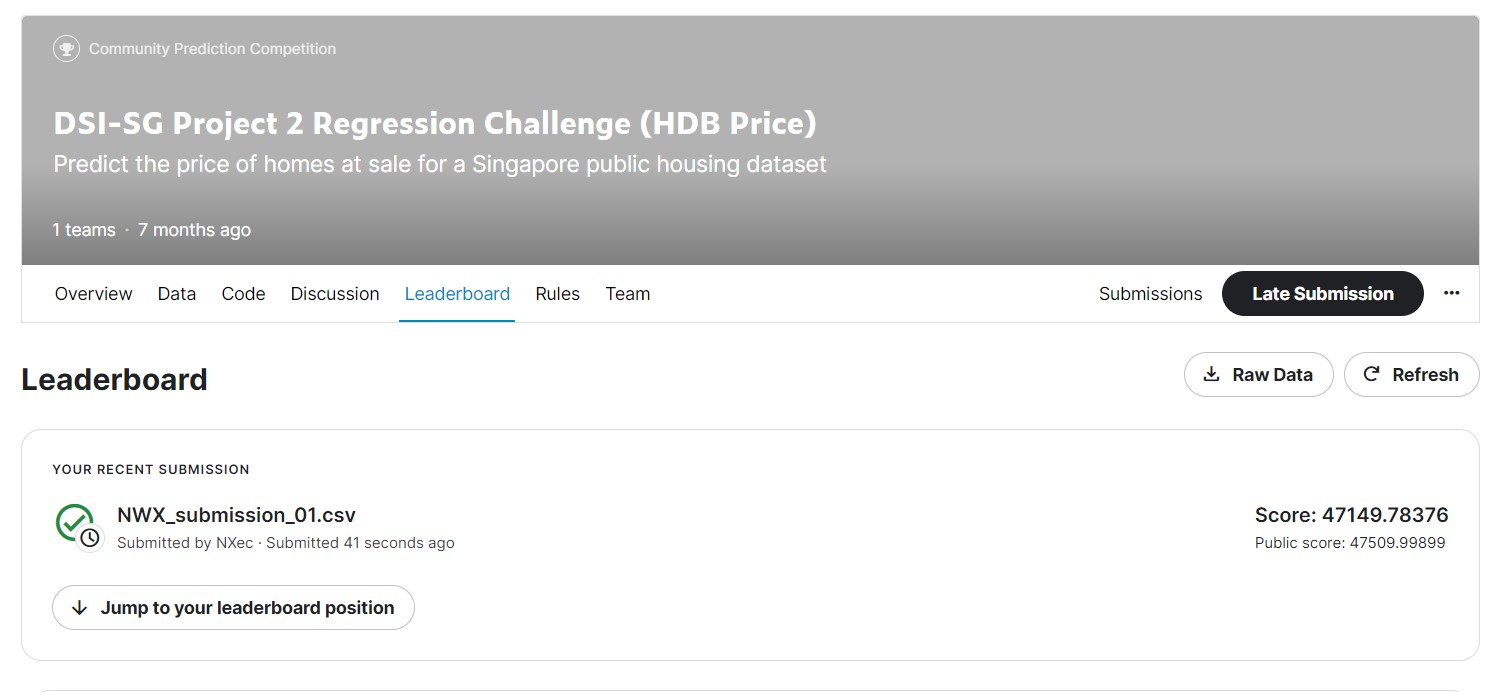

### Final Model 2

For model 2, we did some feature engineering & feature correlation selection in an attempt to improve the model performance but the kaggle score for Linear Regression, Ridge & Lasso model did not perform as expected on unseen data.

In [138]:
model2_df.head()

floor_area_sqm  lease_commence_date  tranc_year  tranc_month  \
0            90.0                 2006        2016            5   
1           130.0                 1987        2012            7   
2           144.0                 1997        2013            7   
3           103.0                 1992        2012            4   
4            83.0                 1987        2017           12   

   max_floor_lvl  residential  commercial  market_hawker  multistorey_carpark  \
0             25            1           0              0                    0   
1              9            1           0              0                    0   
2             16            1           0              0                    0   
3             11            1           1              0                    0   
4              4            1           0              0                    0   

   precinct_pavilion  total_dwelling_units  mall_nearest_distance  \
0                  0                   142            1094.090418   
1                  0                   112             866.941448   
2                  0                    90            1459.579948   
3                  0                    75             950.175199   
4                  0                    48             729.771895   

   hawker_nearest_distance  mrt_nearest_distance  bus_stop_nearest_distance  \
0               154.753357            330.083069                  29.427395   
1               640.151925            903.659703                  58.207761   
2              1762.082341           1334.251197                 214.747860   
3               726.215262            907.453484                  43.396521   
4              1540.151439            412.343032                 129.422752   

   pri_sch_nearest_distance  vacancy  sec_sch_nearest_dist  cutoff_point  \
0               1138.633422       78           1138.633422           224   
1                415.607357       45            447.894399           232   
2                498.849039       39            180.074558           188   
3                389.515528       20            389.515528           253   
4                401.200584       74            312.025435           208   

   housing_region_ccr_1_room  housing_region_ccr_2_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   housing_region_ccr_3_room  housing_region_ccr_4_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   housing_region_ccr_5_room  housing_region_ccr_executive  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   housing_region_ccr_multi_generation  housing_region_rcr_1_room  \
0                                    0                          0   
1                                    0                          0   
2                                    0                          0   
3                                    0                          0   
4                                    0                          0   

   housing_region_rcr_2_room  housing_region_rcr_3_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0    

In [139]:
X = model2_df
y = housing_df['resale_price']

# # apply scaling to X-variables to bring values to a similar scale for better model performance
ss = StandardScaler()
X_sc = ss.fit_transform(X)

# call & fit the model
final_lasso_model_m2 = LassoCV(n_alphas=200)
final_lasso_model_m2.fit(X_sc, y)

# call & fit the model
# final_ridge_model = RidgeCV(alphas=np.linspace(.1, 10, 100))
# final_ridge_model.fit(X_sc, y)

LassoCV(n_alphas=200)

In [140]:
# Get one hot encoded test dataset.
model2_test_df = get_one_hot_encoded(test_df, cat_name_m2, num_name_m2)
model2_test_df.head()

floor_area_sqm  lease_commence_date  tranc_year  tranc_month  \
0            84.0                 1987        2012           11   
1           112.0                 2008        2019            8   
2            68.0                 1980        2013           10   
3            97.0                 1979        2017           10   
4           103.0                 1985        2016            8   

   max_floor_lvl  residential  commercial  market_hawker  multistorey_carpark  \
0             12            1           1              0                    0   
1             14            1           0              0                    0   
2             12            1           0              0                    0   
3             14            1           0              0                    0   
4             25            1           0              0                    0   

   precinct_pavilion  total_dwelling_units  mall_nearest_distance  \
0                  0                   132             877.431572   
1                  0                    53             534.037705   
2                  0                   218             817.050453   
3                  0                   104            1272.737194   
4                  0                   144            1070.963675   

   hawker_nearest_distance  mrt_nearest_distance  bus_stop_nearest_distance  \
0               687.576779            686.660434                  75.683952   
1              2122.346226            169.478175                  88.993058   
2               152.287621            694.220448                  86.303575   
3               501.892158           1117.203587                 108.459039   
4               437.593564            987.976010                 113.645431   

   pri_sch_nearest_distance  vacancy  sec_sch_nearest_dist  cutoff_point  \
0                426.467910       92            156.322353           218   
1                439.756851       45            739.371688           199   
2                355.882207       36            305.071191           245   
3                929.744711       54            433.454591           188   
4                309.926934       40            217.295361           223   

   housing_region_ccr_1_room  housing_region_ccr_2_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   housing_region_ccr_3_room  housing_region_ccr_4_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   

   housing_region_ccr_5_room  housing_region_ccr_executive  \
0                          0                             0   
1                          0                             0   
2                          0                             0   
3                          0                             0   
4                          0                             0   

   housing_region_ccr_multi_generation  housing_region_rcr_1_room  \
0                                    0                          0   
1                                    0                          0   
2                                    0                          0   
3                                    0                          0   
4                                    0                          0   

   housing_region_rcr_2_room  housing_region_rcr_3_room  \
0                          0                          0   
1                          0                          0   
2                          0                          0   
3                          0    

In [141]:
# apply scaling to X-variables to bring values to a similar scale for better model performance
model2_test_sc = ss.transform(model2_test_df)

# Make prediction
y_test_pred_m2 = final_lasso_model_m2.predict(model2_test_sc)
y_test_pred_m2

array([447400.70508362, 639908.99859252, 308932.95964457, ...,
       401556.88456042, 407765.71901914, 361433.42641539])

Preparing the submission csv.

In [142]:
kaggle_sub_m2 = pd.DataFrame(test_df['id'])
kaggle_sub_m2.rename(columns={'id':'Id'}, inplace=True)

In [143]:
# Add in the the prediction
kaggle_sub_m2['Predicted'] = y_test_pred_m2

In [144]:
# Un-comment to create csv
# kaggle_sub_m2.to_csv('../datasets/NWX_submission_02_3.csv', index=False)

#### Model 2 Score:

Submission 2 are all the submissions done for Model 2. None performed better than Model 1.

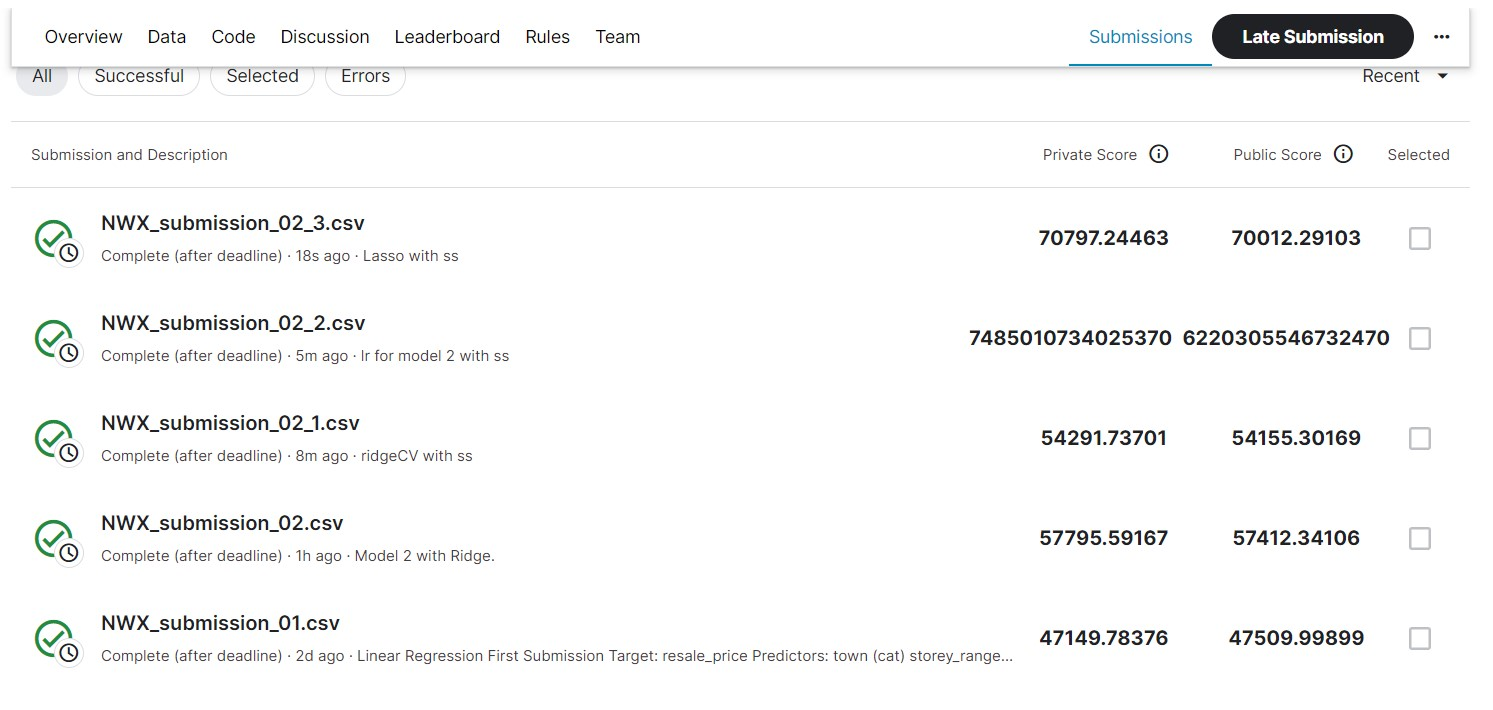

### Final Model 3

Model 3 attempts to improve based on Model 1 features by adjusting the feature selection based on coefficient but did not perform well on unseen data.

In [145]:
model3_df.head()

floor_area_sqm  lease_commence_date  max_floor_lvl  exec_sold  \
0            90.0                 2006             25          0   
1           130.0                 1987              9          0   
2           144.0                 1997             16         60   
3           103.0                 1992             11          0   
4            83.0                 1987              4          0   

   mall_nearest_distance  hawker_nearest_distance  mrt_nearest_distance  \
0            1094.090418               154.753357            330.083069   
1             866.941448               640.151925            903.659703   
2            1459.579948              1762.082341           1334.251197   
3             950.175199               726.215262            907.453484   
4             729.771895              1540.151439            412.343032   

   bus_stop_nearest_distance  pri_sch_nearest_distance  housing_region_OCR  \
0                  29.427395               1138.633422                   0   
1                  58.207761                415.607357                   0   
2                 214.747860                498.849039                   1   
3                  43.396521                389.515528                   0   
4                 129.422752                401.200584                   1   

   enc__town_ang_mo_kio  enc__town_bedok  enc__town_bishan  \
0                   0.0              0.0               0.0   
1                   0.0              0.0               1.0   
2                   0.0              0.0               0.0   
3                   0.0              0.0               1.0   
4                   0.0              0.0               0.0   

   enc__town_bukit_batok  enc__town_bukit_merah  enc__town_bukit_panjang  \
0                    0.0                    0.0                      0.0   
1                    0.0                    0.0                      0.0   
2                    1.0                    0.0                      0.0   
3                    0.0                    0.0                      0.0   
4                    0.0                    0.0                      0.0   

   enc__town_bukit_timah  enc__town_central_area  enc__town_choa_chu_kang  \
0                    0.0                     0.0                      0.0   
1                    0.0                     0.0                      0.0   
2                    0.0                     0.0                      0.0   
3                    0.0                     0.0                      0.0   
4                    0.0                     0.0                      0.0   

   enc__town_clementi  enc__town_geylang  enc__town_hougang  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0   
2                 0.0                0.0                0.0   
3                 0.0                0.0                0.0   
4                 0.0                0.0                0.0   

   enc__town_jurong_east  enc__town_jurong_west  enc__town_kallang/whampoa  \
0                    0.0                    0.0                        1.0   
1                    0.0                    0.0                        0.0   
2                    0.0                    0.0                        0.0   
3                    0.0                    0.0                        0.0   
4                    0.0                    0.0                        0.0   

   enc__town_marine_parade  enc__town_pasir_ris  enc__town_punggol  \
0                      0.0                  0.0                0.0   
1                      0.0                  0.0                0.0   
2                      0.0                  0.0                0.0   
3                      0.0                  0.0                0.0   
4                      0.0                  0.0                0.0   

   enc__town_queenstown  enc__town_sembawang  enc__town_sengkang  \
0                   0.0                  0.0

In [146]:
X = model3_df
y = housing_df['resale_price']

# # apply scaling to X-variables to bring values to a similar scale for better model performance
ss = StandardScaler()
X_sc = ss.fit_transform(X)

# call & fit the model
final_lr_model = LinearRegression()
final_lr_model.fit(X, y)

# call & fit the ridge model
# final_ridge_model = RidgeCV(alphas=np.linspace(.1, 10, 100))
# final_ridge_model.fit(X_sc, y)

# call & fit the lasso model
# final_ridge_model_m2 = LassoCV(n_alphas=200)
# final_ridge_model_m2.fit(X_sc, y)

LinearRegression()

In [147]:
# Get one hot encoded test dataset.
model3_test_df = get_one_hot_encoded(test_df, cat_name_m3, num_name_m3)
model3_test_df.head()

floor_area_sqm  lease_commence_date  max_floor_lvl  exec_sold  \
0            84.0                 1987             12          0   
1           112.0                 2008             14          0   
2            68.0                 1980             12          1   
3            97.0                 1979             14          0   
4           103.0                 1985             25          0   

   mall_nearest_distance  hawker_nearest_distance  mrt_nearest_distance  \
0             877.431572               687.576779            686.660434   
1             534.037705              2122.346226            169.478175   
2             817.050453               152.287621            694.220448   
3            1272.737194               501.892158           1117.203587   
4            1070.963675               437.593564            987.976010   

   bus_stop_nearest_distance  pri_sch_nearest_distance  housing_region_OCR  \
0                  75.683952                426.467910                   0   
1                  88.993058                439.756851                   0   
2                  86.303575                355.882207                   1   
3                 108.459039                929.744711                   0   
4                 113.645431                309.926934                   1   

   enc__town_ang_mo_kio  enc__town_bedok  enc__town_bishan  \
0                   0.0              0.0               0.0   
1                   0.0              0.0               0.0   
2                   1.0              0.0               0.0   
3                   0.0              0.0               0.0   
4                   0.0              0.0               0.0   

   enc__town_bukit_batok  enc__town_bukit_merah  enc__town_bukit_panjang  \
0                    0.0                    0.0                      0.0   
1                    0.0                    0.0                      0.0   
2                    0.0                    0.0                      0.0   
3                    0.0                    0.0                      0.0   
4                    1.0                    0.0                      0.0   

   enc__town_bukit_timah  enc__town_central_area  enc__town_choa_chu_kang  \
0                    0.0                     0.0                      0.0   
1                    0.0                     0.0                      0.0   
2                    0.0                     0.0                      0.0   
3                    0.0                     0.0                      0.0   
4                    0.0                     0.0                      0.0   

   enc__town_clementi  enc__town_geylang  enc__town_hougang  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0   
2                 0.0                0.0                0.0   
3                 0.0                0.0                0.0   
4                 0.0                0.0                0.0   

   enc__town_jurong_east  enc__town_jurong_west  enc__town_kallang/whampoa  \
0                    0.0                    0.0                        0.0   
1                    0.0                    1.0                        0.0   
2                    0.0                    0.0                        0.0   
3                    0.0                    0.0                        0.0   
4                    0.0                    0.0                        0.0   

   enc__town_marine_parade  enc__town_pasir_ris  enc__town_punggol  \
0                      0.0                  0.0                0.0   
1                      0.0                  0.0                0.0   
2                      0.0                  0.0                0.0   
3                      0.0                  0.0                0.0   
4                      0.0                  0.0                0.0   

   enc__town_queenstown  enc__town_sembawang  enc__town_sengkang  \
0                   0.0                  0.0

In [148]:
# apply scaling to X-variables to bring values to a similar scale for better model performance
# model3_test_sc = ss.transform(model3_test_df)

# Make prediction
y_test_pred_m3 = final_lr_model.predict(model3_test_df)
y_test_pred_m3

array([403061.06095675, 554392.52293041, 288722.95604667, ...,
       393872.43812908, 484485.67415664, 338380.65641745])

Preparing the submission csv.

In [149]:
kaggle_sub_m3 = pd.DataFrame(test_df['id'])
kaggle_sub_m3.rename(columns={'id':'Id'}, inplace=True)

In [150]:
# Add in the the prediction
kaggle_sub_m3['Predicted'] = y_test_pred_m3

In [151]:
# Un-comment to create csv
# kaggle_sub_m3.to_csv('../datasets/NWX_submission_03.csv', index=False)

#### Model 3 Score:

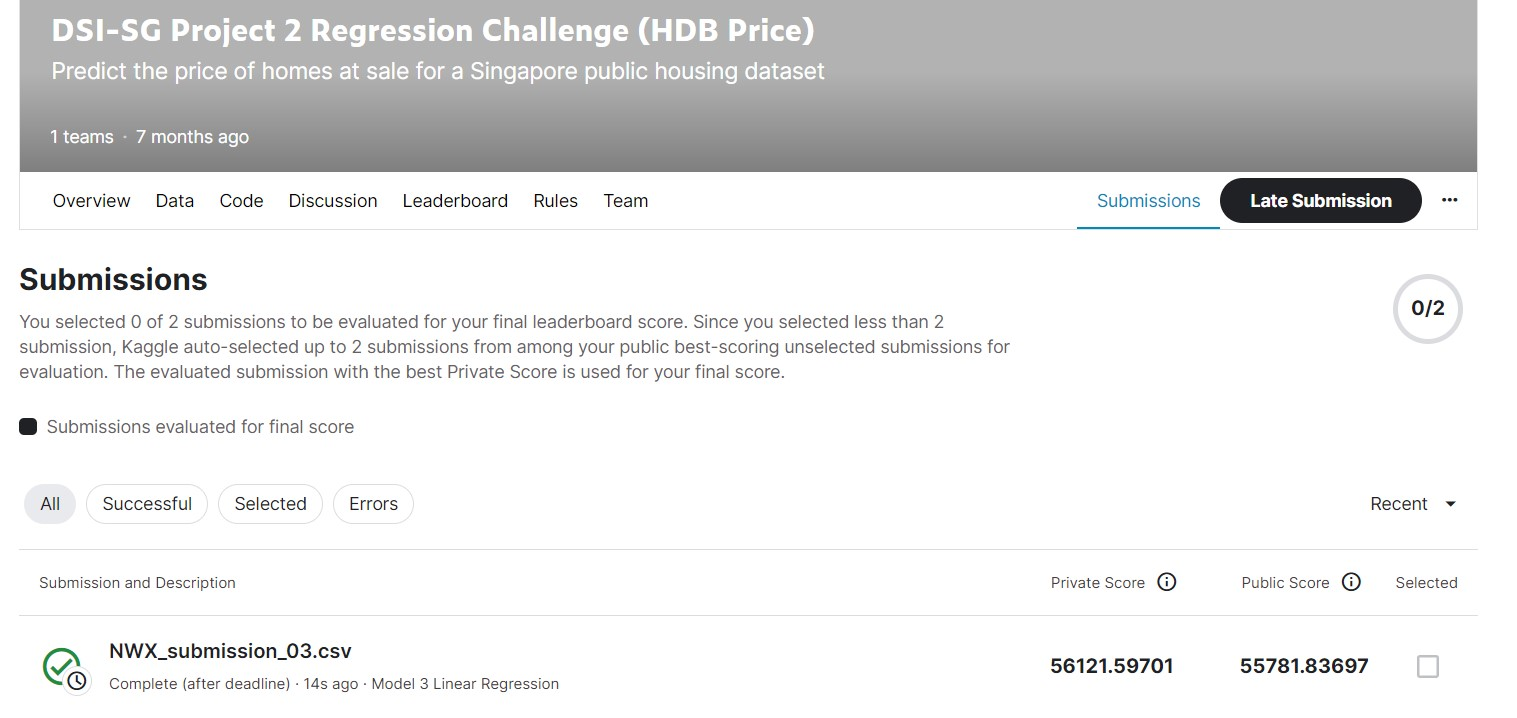

## Key Insights & Recommendations

The following features were found to have the greatest impact on the model we have built:

* Town
* Storey Range
* Full Flat Type
* Pri Sch Name
* Floor Area SQM
* Lease Commencement Date
* MRT Nearest Distance
* Hawker Nearest Distance
* Mall Nearest Distance
* Pri Sch Nearest Distance

* Recommendations for Buyers: 
	* Know your available options given your budget
	* Prioritize and personalize your wants
	* Quality home with comfortable price

* Recommendations for Sellers:
	* Appraise your property value based on market valuation
	* Pivot your selling strategies
	* Match your property’s unique selling points to the right buyers

In [4]:
import pickle

# Load the model from disk
filename = 'model1.sav'  # Make sure to use the same filename
loaded_model = pickle.load(open(filename, 'rb'))

# Now you can use the loaded_model for predictions or further evaluation


C:\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.2.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# Sample input data for prediction
input_data = {
    'town': ['bedok'],
    'storey_range': ['10_to_12'],
    'full_flat_type': ['4_room'],
    'pri_sch_name': ['fengshan_primary_school'],
    'floor_area_sqm': [100],
    'lease_commence_date': [2000],
    'mall_nearest_distance': [500],
    'hawker_nearest_distance': [300],
    'mrt_nearest_distance': [200],
    'pri_sch_nearest_distance': [100],
    'sec_sch_nearest_dist': [150]
}

# Convert the input data into a DataFrame
df_input = pd.DataFrame(input_data)


In [7]:
# Load the saved transformer for one-hot encoding (if it was saved separately)
# For demonstration, let's create the transformer as you had in your Streamlit app
cat_features = ['town', 'storey_range', 'full_flat_type', 'pri_sch_name']
num_features = ['floor_area_sqm', 'lease_commence_date', 'mall_nearest_distance', 'hawker_nearest_distance', 
                'mrt_nearest_distance', 'pri_sch_nearest_distance', 'sec_sch_nearest_dist']

onehotencoder = OneHotEncoder(handle_unknown='ignore')
transformer_m1 = ColumnTransformer([("enc", onehotencoder, cat_features)], remainder="passthrough")

# Assuming you already fit the transformer on the training data, transform the input data
df_input_transformed = pd.DataFrame(transformer_m1.fit_transform(df_input))

# If you had saved the transformer earlier, you could load it as follows:
# with open('transformer_m1.pkl', 'rb') as f:
#     transformer_m1 = pickle.load(f)
# df_input_transformed = pd.DataFrame(transformer_m1.transform(df_input))
